In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import datetime

#  랜덤포레스트모델

In [ ]:
today = pd.datetime.now()
today_str = str(today)[:10].replace('-','')
wth_df = pd.read_csv('wth_data_20211025.csv',index_col=1).fillna(0)
wth_df.drop('Unnamed: 0', axis=1, inplace=True)
wth_df.index = wth_df.index.astype('datetime64[ns]')

# 종합주가 지수 데이터프레임 파일 구축
import FinanceDataReader as fdr
ks = fdr.DataReader('KS11', '2000').dropna() 
ks.drop(['Open', 'High', 'Low'], axis =1, inplace = True)
kq= fdr.DataReader('KQ11','2000').dropna()
kq.drop(['Open', 'High', 'Low'], axis =1, inplace= True)
krx = fdr.StockListing('KRX')

In [22]:
df_theme_code_result.head()

,0,1,2,3
0,"['035720', '035420']","[0.914081385006083, 0.9294957089483262]","[0.3749234046455977, 0.4799527269495656]","[-3.2903325276686726, -6.699418337488754]"


In [23]:
pwd

'/Users/parksinae/Documents/fp_team'

In [47]:
path = glob.glob('./data/테마별 주식데이터/*.csv')

for csv_path in path :
    df_theme_code_result = pd.read_csv(csv_path,index_col=0)
    df_theme_code_result = df_theme_code_result.set_index(df_theme_code_result['Date'])
    df_theme_code_result.drop('Date',axis=1,inplace=True)
    df_theme_code_result.cd = df_theme_code_result.cd.apply(lambda x : str(x).zfill(6))


    df_list=[]
    cdd=[]
    train_score=[]
    test_score =[]
    pred_score =[]


    for i in range(len(df_theme_code_result.cd.unique())) : 
        code = df_theme_code_result.cd.unique()[i]
        df = df_theme_code_result[df_theme_code_result['cd']==code]
        df_list.append(df)

    for j in range(len(df_list)) : 
        df_list[j].index = df_list[j].index.astype('datetime64[ns]')
        df_list[j].fillna(0)


        #종합주가 지수 영향 제거
        if (krx[krx['Symbol'] ==df_list[j].cd.iloc[0]].iloc[0,1])=='KOSPI':
            df_list[j]['n_close'] = df_list[j]['Close']*(1 - ks['Change'])
        else :
            df_list[j]['n_close'] = df_list[j]['Close']*(1 - kq['Change'])


        wth_al = pd.merge(df_list[j], wth_df,left_index=True, right_index=True).dropna()# 위 데이터+ 날씨


        # 모델용/ 예측용 구분
        wth_alm = wth_al.loc[:'2019-12-31',:].dropna()
        wth_alp = wth_al.loc['2020-01-04':,:].dropna()

        # target/test 구분
        target = wth_alm['n_close'].to_numpy()
        data = wth_alm.drop(['n_close', 'Close', 'Volume', 'Change','cd'], axis=1).to_numpy()

        p_target = wth_alp['n_close'].to_numpy()
        p_data = wth_alp.drop(['n_close', 'Close', 'Volume', 'Change','cd'], axis=1).to_numpy()

        try:
            from sklearn.model_selection import train_test_split
            x_train, x_test, y_train, y_test = train_test_split(data, target, test_size=0.2, random_state=42)

            # 표준화
            from sklearn.preprocessing import StandardScaler
            ss = StandardScaler()
            ss.fit(x_train)
            tr_scaled =ss.transform(x_train)
            ts_scaled =ss.transform(x_test)
            p_scaled = ss.transform(p_data)

            # 모델 구축

            from sklearn.ensemble import RandomForestRegressor

            rfr =RandomForestRegressor()
            rfr.fit(tr_scaled, y_train)
            tr_score= rfr.score(tr_scaled, y_train)
            ts_score= rfr.score(ts_scaled, y_test)
            ps_score = rfr.score(p_scaled, p_target)
            cdd.append(df_list[j].cd.iloc[0])
            train_score.append(tr_score)
            test_score.append(ts_score)
            pred_score.append(ps_score)

        except Exception:
            cdd.append('error')# 최근 상장되어 데이터가 없어 오류 날 경우 패스
            pass
    rt_data= pd.DataFrame([cdd, train_score, test_score, pred_score])
    rt_data.to_csv('./data/{}_data.csv'.format(df_list[j].cd.iloc[0]))

<ipython-input-47-7d7dd4db41c5>:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_list[j]['n_close'] = df_list[j]['Close']*(1 - kq['Change'])
<ipython-input-47-7d7dd4db41c5>:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_list[j]['n_close'] = df_list[j]['Close']*(1 - kq['Change'])
<ipython-input-47-7d7dd4db41c5>:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation:

<ipython-input-47-7d7dd4db41c5>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_list[j]['n_close'] = df_list[j]['Close']*(1 - ks['Change'])
<ipython-input-47-7d7dd4db41c5>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_list[j]['n_close'] = df_list[j]['Close']*(1 - ks['Change'])
<ipython-input-47-7d7dd4db41c5>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation:

<ipython-input-47-7d7dd4db41c5>:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_list[j]['n_close'] = df_list[j]['Close']*(1 - kq['Change'])
<ipython-input-47-7d7dd4db41c5>:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_list[j]['n_close'] = df_list[j]['Close']*(1 - kq['Change'])
<ipython-input-47-7d7dd4db41c5>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation:

<ipython-input-47-7d7dd4db41c5>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_list[j]['n_close'] = df_list[j]['Close']*(1 - ks['Change'])
<ipython-input-47-7d7dd4db41c5>:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_list[j]['n_close'] = df_list[j]['Close']*(1 - kq['Change'])
<ipython-input-47-7d7dd4db41c5>:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation:

<ipython-input-47-7d7dd4db41c5>:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_list[j]['n_close'] = df_list[j]['Close']*(1 - kq['Change'])
<ipython-input-47-7d7dd4db41c5>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_list[j]['n_close'] = df_list[j]['Close']*(1 - ks['Change'])
<ipython-input-47-7d7dd4db41c5>:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation:

<ipython-input-47-7d7dd4db41c5>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_list[j]['n_close'] = df_list[j]['Close']*(1 - ks['Change'])
<ipython-input-47-7d7dd4db41c5>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_list[j]['n_close'] = df_list[j]['Close']*(1 - ks['Change'])


In [80]:
df = pd.read_csv('017390_data_도시가스.csv', index_col=0)
df2 = df.T
df3 = pd.DataFrame(columns=[0,1,2,3])
for i in range(len(df2.index)) : 
    k = df2.iloc[i].tolist()[0][1:-2].replace("'","").split(',')
    for j in range(len(k)):
        df3.loc[i,j] = k[j].strip()
gas = df3.T
gas['th']='gas'

In [81]:
gas.head()

,0,1,2,3,th
0,036460,0.9015740029021433,0.2930535731267536,-4.260677185993262,gas
1,053050,0.8778943297674744,0.163230649427333,-0.21985206272383495,gas
2,004690,0.8982318075858686,0.2713208477667979,-6.768735243826691,gas
3,015350,0.9258290259629944,0.46417716352488403,-3.49688031860021,gas
4,015360,0.9225680976557625,0.42844174271545266,-12.827649879404833,gas


In [82]:
df = pd.read_csv('000020_data_겨울.csv', index_col=0)
df2 = df.T
df3 = pd.DataFrame(columns=[0,1,2,3])
for i in range(len(df2.index)) : 
    k = df2.iloc[i].tolist()[0][1:-2].replace("'","").split(',')
    for j in range(len(k)):
        df3.loc[i,j] = k[j].strip()
wt = df3.T
wt['th']='winter'

In [83]:
df = pd.read_csv('025860_data_태퐁및장마.csv', index_col=0)
df2 = df.T
df3 = pd.DataFrame(columns=[0,1,2,3])
for i in range(len(df2.index)) : 
    k = df2.iloc[i].tolist()[0][1:-2].replace("'","").split(',')
    for j in range(len(k)):
        df3.loc[i,j] = k[j].strip()
tp = df3.T
tp['th']='typoon'

In [84]:
df = pd.read_csv('035420_data_인터넷대표주.csv', index_col=0)
df2 = df.T
df3 = pd.DataFrame(columns=[0,1,2,3])
for i in range(len(df2.index)) : 
    k = df2.iloc[i].tolist()[0][1:-2].replace("'","").split(',')
    for j in range(len(k)):
        df3.loc[i,j] = k[j].strip()
inte = df3.T
inte['th']='internet'

In [86]:
df = pd.read_csv('039310_data_여행.csv', index_col=0)
df2 = df.T
df3 = pd.DataFrame(columns=[0,1,2,3])
for i in range(len(df2.index)) : 
    k = df2.iloc[i].tolist()[0][1:-2].replace("'","").split(',')
    for j in range(len(k)):
        df3.loc[i,j] = k[j].strip()
trip = df3.T
trip['th']='trip'

In [ ]:
df = pd.read_csv('058610_data_제습기.csv', index_col=0)
df2 = df.T
df3 = pd.DataFrame(columns=[0,1,2,3])
for i in range(len(df2.index)) : 
    k = df2.iloc[i].tolist()[0][1:-2].replace("'","").split(',')
    for j in range(len(k)):
        df3.loc[i,j] = k[j].strip()
jes = df3.T
jes['th']='jesp'

In [91]:
df = pd.read_csv('313760_data_태양광에너지.csv', index_col=0)
df2 = df.T
df3 = pd.DataFrame(columns=[0,1,2,3])
for i in range(len(df2.index)) : 
    k = df2.iloc[i].tolist()[0][1:-2].replace("'","").split(',')
    for j in range(len(k)):
        df3.loc[i,j] = k[j].strip()
solar = df3.T
solar['th']='solar power'

In [ ]:
score_al = pd.concat([gas,wt,tp,inte,trip,jes,solar])

In [105]:
score_al.to_csv('score_al.csv')
score_al

,0,1,2,3,th
0,036460,0.901574,0.293054,-4.260677,gas
1,053050,0.877894,0.163231,-0.219852,gas
2,004690,0.898232,0.271321,-6.768735,gas
3,015350,0.925829,0.464177,-3.496880,gas
4,015360,0.922568,0.428442,-12.827650,gas
...,...,...,...,...,...
45,119650,0.929089,0.482608,-0.720695,solar power
46,078600,0.925239,0.411390,-3.225650,solar power
47,017040,0.917275,0.375315,-1.214882,solar power
48,121600,0.923908,0.479017,-1.878806,solar power


In [96]:
score_al.groupby(by ='th').count()

,0,1,2,3
th,,,,
gas,10,10,10,10
internet,2,2,2,2
jesp,9,9,9,9
solar power,50,50,50,50
trip,9,9,9,9
typoon,9,9,9,9
winter,23,23,23,23


In [104]:
score_al[1]=score_al[1].astype('float64')
score_al[2]=score_al[2].astype('float64')
score_al[3]=score_al[3].astype('float64')

In [106]:
score_al.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 114 entries, 0 to 49
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       112 non-null    object 
 1   1       112 non-null    float64
 2   2       112 non-null    float64
 3   3       112 non-null    float64
 4   th      114 non-null    object 
dtypes: float64(3), object(2)
memory usage: 5.3+ KB


In [118]:
n={1:'train_score',2:'test_score',3: 'pred_score'}
score_al =score_al.rename(columns=n)

# 그룹별  평균 비교

In [119]:
score_al.groupby('th').mean()

,train_score,test_score,pred_score
th,,,
gas,0.914635,0.379790,-4.322627
internet,0.921435,0.429613,-4.972955
jesp,0.927416,0.502206,-7.516360
solar power,0.915420,0.402530,-3449.911411
trip,0.914214,0.410263,-0.966971
typoon,0.910316,0.362193,-56.112654
winter,0.917773,0.399959,-7.377167


# 별 차이 없음

In [131]:
score_al.head(10)

,0,train_score,test_score,pred_score,th
0,036460,0.901574,0.293054,-4.260677,gas
1,053050,0.877894,0.163231,-0.219852,gas
2,004690,0.898232,0.271321,-6.768735,gas
3,015350,0.925829,0.464177,-3.496880,gas
4,015360,0.922568,0.428442,-12.827650,gas
5,267290,0.935545,0.613979,-10.309183,gas
6,016710,0.912407,0.361728,-2.038957,gas
7,117580,0.928680,0.365103,-0.008646,gas
8,034590,0.929951,0.476049,-1.910409,gas
9,017390,0.913672,0.360814,-1.385280,gas


In [122]:
score_al[score_al['train_score'].max()== score_al['train_score']]

,0,train_score,test_score,pred_score,th
6,104620,0.994903,0.987968,-0.518718,trip


In [124]:
score_al[score_al['test_score'].max()== score_al['test_score']]

,0,train_score,test_score,pred_score,th
6,104620,0.994903,0.987968,-0.518718,trip


In [143]:
score_al.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 114 entries, 0 to 49
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   0            112 non-null    object 
 1   train_score  112 non-null    float64
 2   test_score   112 non-null    float64
 3   pred_score   112 non-null    float64
 4   th           114 non-null    object 
dtypes: float64(3), object(2)
memory usage: 5.3+ KB


In [182]:
score_al['train_score'].sort_values(ascending=False)[:10]

0
104620    0.994903
284740    0.963508
140670    0.958896
210980    0.953125
071460    0.945067
215000    0.941808
042700    0.939554
005930    0.939518
064760    0.938974
095610    0.938728
Name: train_score, dtype: float64

In [183]:
score_al['test_score'].sort_values(ascending=False)[:10]

0
104620    0.987968
284740    0.770142
313760    0.714298
140670    0.706158
322000    0.637745
071460    0.628289
215000    0.615611
267290    0.613979
267290    0.608198
281740    0.583054
Name: test_score, dtype: float64

In [ ]:
# 높은 것

In [168]:
score_al.loc['104620',:] # 노랑풍선

train_score    0.994903
test_score     0.987968
pred_score    -0.518718
th                 trip
Name: 104620, dtype: object

In [167]:
 score_al.loc['284740',:] # 쿠쿠 홈시스

train_score    0.963508
test_score     0.770142
pred_score    -0.421168
th                 jesp
Name: 284740, dtype: object

In [184]:
score_al.loc['140670',:] # 알에스오토메이션

train_score       0.958896
test_score        0.706158
pred_score      -10.525453
th             solar power
Name: 140670, dtype: object

In [158]:
score_al =score_al.set_index(0)

In [ ]:
# 낮은것

In [177]:
score_al['train_score'].sort_values(ascending=True)[:10]

0
053050    0.877894
003070    0.880262
053050    0.881704
039020    0.885218
036930    0.886179
025860    0.886220
050760    0.887009
004710    0.890701
048550    0.890946
009540    0.892778
Name: train_score, dtype: float64

In [176]:
score_al['test_score'].sort_values(ascending=True)[:10]

0
003070    0.127142
053050    0.163231
053050    0.164176
025860    0.168567
109610    0.184240
039020    0.192447
009540    0.208492
004710    0.213471
010060    0.217079
050760    0.218392
Name: test_score, dtype: float64

In [178]:
score_al.loc['053050',:] # 지에스이

,train_score,test_score,pred_score,th
0,,,,
053050,0.877894,0.163231,-0.219852,gas
053050,0.881704,0.164176,-0.275261,winter


In [179]:
 score_al.loc['003070',:] # 코오롱 글로벌

train_score       0.880262
test_score        0.127142
pred_score       -2.041478
th             solar power
Name: 003070, dtype: object

In [181]:
score_al.loc['039020',:] # 이건 홀딩스

train_score       0.885218
test_score        0.192447
pred_score        0.023631
th             solar power
Name: 039020, dtype: object

In [ ]:
# 신재생 에너지 관련은 특히 영향을 받지 않는 듯

In [15]:
od=['여름','인터넷 대표주','겨울','태양광 에너지', '여행','제습기']

[]

# 그리드서치

In [ ]:
params = {'max_depth':rand}

In [330]:

df_list=[]

for i in range(len(df_theme_code_result.cd.unique())) : 
    code = df_theme_code_result.cd.unique()[i]
    df = df_theme_code_result[df_theme_code_result['cd']==code]
    df_list.append(df)

# 종합주가 지수 데이터프레임 파일 구축
import FinanceDataReader as fdr
ks = fdr.DataReader('KS11', '2000').dropna() 
ks.drop(['Open', 'High', 'Low'], axis =1, inplace = True)
kq= fdr.DataReader('KQ11','2000').dropna()
kq.drop(['Open', 'High', 'Low'], axis =1, inplace= True)
krx = fdr.StockListing('KRX')

code=
train_score = [] ## 테마별 모델 설명력 비교위한 트레인/테스트 스코어 리스트 작성
test_score = []
    
for j in range(len(df_list)) : 
    df_list[j].index = df_list[j].index.astype('datetime64[ns]')
    df_list[j].fillna(0)
    
    #종합주가 지수 영향 제거
    if (krx[krx['Symbol'] ==df_list[j].cd.iloc[0]].iloc[0,1])=='KOSPI':
        df_list[j]['n_close'] = df_list[j]['Close'] - (df_list[j]['Close']*ks['Change'])
        print('KOSPI')
    else :
        df_list[j]['n_close'] = df_list[j]['Close'] - (df_list[j]['Close']*kq['Change'])
        print('KOSDAQ')
    
        # 기본 데이터셋 만들기
    df_list[j].index = df_list[j].index.astype('datetime64[ns]')
    pri_ks = pd.merge(df_list[j], ks, left_index=True, right_index=True)# 코스피+두나무관련주 데이터1번(신성이앤지)
    wth_al = pd.merge(wth_df, pri_ks, left_index=True, right_index=True)# 위 데이터+ 날씨
    
    
    # 모델용/ 예측용 구분
    wth_alm = wth_al.loc[:'2019-12-31',:].dropna()
    wth_alp = wth_al.loc['2020-01-04':,:]

    # target/test 구분
    target = wth_alm['n_close'].to_numpy()
    data = wth_alm.drop(['n_close', 'Close_x', 'Volume_x', 'Change_x','cd','Volume_y','Close_y','Change_y'], axis=1).to_numpy()

    p_target = wth_alp['n_close'].to_numpy()
    p_data = wth_alp.drop(['n_close', 'Close_x', 'Volume_x', 'Change_x','cd','Volume_y','Close_y','Change_y'], axis=1).to_numpy()

    from sklearn.model_selection import train_test_split
    x_train, x_test, y_train, y_test = train_test_split(data, target, test_size=0.2, random_state=42)

    # 표준화
    from sklearn.preprocessing import StandardScaler
    ss = StandardScaler()
    ss.fit(x_train)
    tr_scaled =ss.transform(x_train)
    ts_scaled =ss.transform(x_test)
    p_scaled = ss.transform(p_data)

    # 모델 구축

    from sklearn.ensemble import RandomForestRegressor

    rfr =RandomForestRegressor()
    rfr.fit(tr_scaled, y_train)
    tr_score= rfr.score(tr_scaled, y_train)
    ts_score= rfr.score(ts_scaled, y_test)
    train_score.append(tr_score)
    test_score.append(ts_score)
    

    print(df_list[j].cd.iloc[0])
    print('----------------')
    print('RandomForestRegressor train 정확도:', tr_score)
    print('RandomForestRegressor test 정확도:', ts_score)
    print('RandomForestRegressor prediction 정확도:', rfr.score(p_scaled, p_target))
    print('---------------------------------------------')

print('train_정확도 평균',theme_nm, np.mean(train_score))# 해당 테마 설명력 평균 점수
print('test_정확도 평균',theme_nm, np.mean(test_score))

<ipython-input-330-0b83720a22bc>:1: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  today = pd.datetime.now()
<ipython-input-330-0b83720a22bc>:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_list[j]['n_close'] = df_list[j]['Close'] - (df_list[j]['Close']*ks['Change'])


KOSPI
011930
----------------
RandomForestRegressor train 정확도: 0.9101751257532762
RandomForestRegressor test 정확도: 0.3373131247683042
RandomForestRegressor prediction 정확도: -1.3341859591488165
---------------------------------------------
KOSDAQ


<ipython-input-330-0b83720a22bc>:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_list[j]['n_close'] = df_list[j]['Close'] - (df_list[j]['Close']*kq['Change'])


246690
----------------
RandomForestRegressor train 정확도: 0.9411798225821785
RandomForestRegressor test 정확도: 0.6455412409040177
RandomForestRegressor prediction 정확도: -0.3230899899406423
---------------------------------------------
KOSDAQ


<ipython-input-330-0b83720a22bc>:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_list[j]['n_close'] = df_list[j]['Close'] - (df_list[j]['Close']*kq['Change'])


041190
----------------
RandomForestRegressor train 정확도: 0.9402547580212536
RandomForestRegressor test 정확도: 0.5770258886515803
RandomForestRegressor prediction 정확도: -1.7930979608234696
---------------------------------------------
KOSDAQ


<ipython-input-330-0b83720a22bc>:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_list[j]['n_close'] = df_list[j]['Close'] - (df_list[j]['Close']*kq['Change'])


018700
----------------
RandomForestRegressor train 정확도: 0.9124107554408863
RandomForestRegressor test 정확도: 0.4688226900601574
RandomForestRegressor prediction 정확도: -355.8026342931292
---------------------------------------------
KOSDAQ


<ipython-input-330-0b83720a22bc>:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_list[j]['n_close'] = df_list[j]['Close'] - (df_list[j]['Close']*kq['Change'])


021080
----------------
RandomForestRegressor train 정확도: 0.9409901500034797
RandomForestRegressor test 정확도: 0.5137254932432347
RandomForestRegressor prediction 정확도: -1.7108721180488011
---------------------------------------------
KOSDAQ


<ipython-input-330-0b83720a22bc>:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_list[j]['n_close'] = df_list[j]['Close'] - (df_list[j]['Close']*kq['Change'])


027830
----------------
RandomForestRegressor train 정확도: 0.9322810039440765
RandomForestRegressor test 정확도: 0.494224908222085
RandomForestRegressor prediction 정확도: -1.8593441119117102
---------------------------------------------
KOSPI


<ipython-input-330-0b83720a22bc>:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_list[j]['n_close'] = df_list[j]['Close'] - (df_list[j]['Close']*ks['Change'])


003530
----------------
RandomForestRegressor train 정확도: 0.8867021333929778
RandomForestRegressor test 정확도: 0.1744958877127939
RandomForestRegressor prediction 정확도: -0.9565594615646598
---------------------------------------------
KOSDAQ


<ipython-input-330-0b83720a22bc>:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_list[j]['n_close'] = df_list[j]['Close'] - (df_list[j]['Close']*kq['Change'])


241520
----------------
RandomForestRegressor train 정확도: 0.9473040882403946
RandomForestRegressor test 정확도: 0.6938262076429726
RandomForestRegressor prediction 정확도: -0.20746620361763624
---------------------------------------------
KOSPI


<ipython-input-330-0b83720a22bc>:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_list[j]['n_close'] = df_list[j]['Close'] - (df_list[j]['Close']*ks['Change'])


035720
----------------
RandomForestRegressor train 정확도: 0.9148294627289155
RandomForestRegressor test 정확도: 0.38290408386247843
RandomForestRegressor prediction 정확도: -3.2689694290001006
---------------------------------------------
KOSPI


<ipython-input-330-0b83720a22bc>:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_list[j]['n_close'] = df_list[j]['Close'] - (df_list[j]['Close']*ks['Change'])


002020
----------------
RandomForestRegressor train 정확도: 0.9150558770072991
RandomForestRegressor test 정확도: 0.37095483091207193
RandomForestRegressor prediction 정확도: -2.5388264179163555
---------------------------------------------
KOSPI


<ipython-input-330-0b83720a22bc>:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_list[j]['n_close'] = df_list[j]['Close'] - (df_list[j]['Close']*ks['Change'])


120110
----------------
RandomForestRegressor train 정확도: 0.920882483963837
RandomForestRegressor test 정확도: 0.331996803149068
RandomForestRegressor prediction 정확도: -0.8586877850958206
---------------------------------------------
train_정확도 평균 두나무 관련주 0.9238241510071432
test_정확도 평균 두나무 관련주 0.4537119235571604


In [ ]:
# 기상연관성 높은 기업/납은 기업 한두개에 대해서 feature 중요도 비교

In [328]:
# feature 중요도
ftres = wth_alm.drop(['n_close', 'Close_x', 'Volume_x', 'Change_x','cd','Volume_y','Change_y', 'Close_y'], axis=1).columns
pd.DataFrame(np.round(rfr.feature_importances_, 3), index=ftres).sort_values(0, ascending=False)

,0
3m지중온도,0.138
1.5m지중온도,0.115
평균30cm지중온도,0.060
1시간최다일사량,0.056
가조시간,0.055
0.5m지중온도,0.041
대형증발량,0.040
소형증발량,0.035
합계일사량,0.032
최대풍속,0.032


<Figure size 1152x576 with 0 Axes>

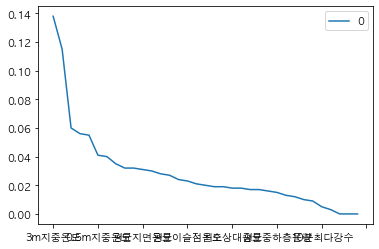

In [329]:
# 특성중요도 시각화
plt.figure(figsize =(16,8))
pd.DataFrame(np.round(rfr.feature_importances_, 3), index=ftres).sort_values(0, ascending=False).plot(kind='line')
plt.show()

# 그래디언트 부스팅 모델 (기본 설정 그대로 적용)

In [326]:
# today = pd.datetime.now()
# today_str = str(today)[:10].replace('-','')

# theme_nm='두나무 관련주'
# # path = '{}_list_{}.csv'.format(theme_nm, today_str)
# path = '두나무 관련주_list_20211026.csv'

# df_theme_code_result = pd.read_csv(path,index_col=0)
# df_theme_code_result = df_theme_code_result.set_index(df_theme_code_result['Date'])
# df_theme_code_result.drop('Date',axis=1,inplace=True)
# df_theme_code_result.cd = df_theme_code_result.cd.apply(lambda x : str(x).zfill(6))

# df_list=[]

# for i in range(len(df_theme_code_result.cd.unique())) : 
#     code = df_theme_code_result.cd.unique()[i]
#     df = df_theme_code_result[df_theme_code_result['cd']==code]
#     df_list.append(df)

# # 종합주가 지수 데이터프레임 파일 구축
# import FinanceDataReader as fdr
# ks = fdr.DataReader('KS11', '2000').dropna() 
# ks.drop(['Open', 'High', 'Low'], axis =1, inplace = True)
# kq= fdr.DataReader('KQ11','2000').dropna()
# kq.drop(['Open', 'High', 'Low'], axis =1, inplace= True)
# krx = fdr.StockListing('KRX')

    
for j in range(len(df_list)) : 
    df_list[j].index = df_list[j].index.astype('datetime64[ns]')
    df_list[j].fillna(0)
    
    #종합주가 지수 영향 제거
    if (krx[krx['Symbol'] ==df_list[j].cd.iloc[0]].iloc[0,1])=='KOSPI':
        df_list[j]['n_close'] = df_list[j]['Close'] - (df_list[j]['Close']*ks['Change'])
        print('KOSPI')
    else :
        df_list[j]['n_close'] = df_list[j]['Close'] - (df_list[j]['Close']*kq['Change'])
        print('KOSDAQ')
    
        # 기본 데이터셋 만들기
    df_list[j].index = df_list[j].index.astype('datetime64[ns]')
    pri_ks = pd.merge(df_list[j], ks, left_index=True, right_index=True)# 코스피+두나무관련주 데이터1번(신성이앤지)
    wth_al = pd.merge(wth_df, pri_ks, left_index=True, right_index=True)# 위 데이터+ 날씨
    
    
    # 모델용/ 예측용 구분
    wth_alm = wth_al.loc[:'2019-12-31',:].dropna()
    wth_alp = wth_al.loc['2020-01-04':,:]

    # target/test 구분
    target = wth_alm['n_close'].to_numpy()
    data = wth_alm.drop(['n_close', 'Close_x', 'Volume_x', 'Change_x','cd','Volume_y','Close_y','Change_y'], axis=1).to_numpy()

    p_target = wth_alp['n_close'].to_numpy()
    p_data = wth_alp.drop(['n_close', 'Close_x', 'Volume_x', 'Change_x','cd','Volume_y','Close_y','Change_y'], axis=1).to_numpy()

    from sklearn.model_selection import train_test_split
    x_train, x_test, y_train, y_test = train_test_split(data, target, test_size=0.2, random_state=42)

    # 표준화
    from sklearn.preprocessing import StandardScaler
    ss = StandardScaler()
    ss.fit(x_train)
    tr_scaled =ss.transform(x_train)
    ts_scaled =ss.transform(x_test)
    p_scaled = ss.transform(p_data)

    # 모델 구축
    from sklearn.ensemble import GradientBoostingRegressor
    gb = GradientBoostingRegressor(random_state=42)
    gb.fit(tr_scaled, y_train)


    print('---------------------------------------------')
    print(df_list[j].cd.iloc[0])
    print('----------------')
    print('GradientBoostingRegressor train 정확도:', gb.score(tr_scaled, y_train))
    print('GradientBoostingRegressor test 정확도:', gb.score(ts_scaled, y_test))
    print('GradientBoostingRegressor prediction 정확도:', gb.score(p_scaled, p_target))

    print('---------------------------------------------')


<ipython-input-326-7511333f31b5>:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_list[j]['n_close'] = df_list[j]['Close'] - (df_list[j]['Close']*ks['Change'])


KOSPI
---------------------------------------------
011930
----------------
GradientBoostingRegressor train 정확도: 0.3832439758368906
GradientBoostingRegressor test 정확도: 0.2584769928018198
GradientBoostingRegressor prediction 정확도: -0.9662332919722798
---------------------------------------------
KOSDAQ


<ipython-input-326-7511333f31b5>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_list[j]['n_close'] = df_list[j]['Close'] - (df_list[j]['Close']*kq['Change'])


---------------------------------------------
246690
----------------
GradientBoostingRegressor train 정확도: 0.8565050774506453
GradientBoostingRegressor test 정확도: 0.6530073093357306
GradientBoostingRegressor prediction 정확도: -0.345598000174103
---------------------------------------------
KOSDAQ


<ipython-input-326-7511333f31b5>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_list[j]['n_close'] = df_list[j]['Close'] - (df_list[j]['Close']*kq['Change'])


---------------------------------------------
041190
----------------
GradientBoostingRegressor train 정확도: 0.6823947800456729
GradientBoostingRegressor test 정확도: 0.49217752686990945
GradientBoostingRegressor prediction 정확도: -1.8503915727859659
---------------------------------------------
KOSDAQ


<ipython-input-326-7511333f31b5>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_list[j]['n_close'] = df_list[j]['Close'] - (df_list[j]['Close']*kq['Change'])


---------------------------------------------
018700
----------------
GradientBoostingRegressor train 정확도: 0.5679884159864586
GradientBoostingRegressor test 정확도: 0.41246661357818015
GradientBoostingRegressor prediction 정확도: -253.17144497684535
---------------------------------------------
KOSDAQ


<ipython-input-326-7511333f31b5>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_list[j]['n_close'] = df_list[j]['Close'] - (df_list[j]['Close']*kq['Change'])


---------------------------------------------
021080
----------------
GradientBoostingRegressor train 정확도: 0.6233186179474911
GradientBoostingRegressor test 정확도: 0.4524226388943272
GradientBoostingRegressor prediction 정확도: -1.678460671154769
---------------------------------------------
KOSDAQ


<ipython-input-326-7511333f31b5>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_list[j]['n_close'] = df_list[j]['Close'] - (df_list[j]['Close']*kq['Change'])


---------------------------------------------
027830
----------------
GradientBoostingRegressor train 정확도: 0.5727541183479681
GradientBoostingRegressor test 정확도: 0.42564181345714514
GradientBoostingRegressor prediction 정확도: -1.7924583364319884
---------------------------------------------
KOSPI


<ipython-input-326-7511333f31b5>:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_list[j]['n_close'] = df_list[j]['Close'] - (df_list[j]['Close']*ks['Change'])


---------------------------------------------
003530
----------------
GradientBoostingRegressor train 정확도: 0.27884105386007185
GradientBoostingRegressor test 정확도: 0.12660260414612556
GradientBoostingRegressor prediction 정확도: -0.670778770914217
---------------------------------------------
KOSDAQ


<ipython-input-326-7511333f31b5>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_list[j]['n_close'] = df_list[j]['Close'] - (df_list[j]['Close']*kq['Change'])


---------------------------------------------
241520
----------------
GradientBoostingRegressor train 정확도: 0.8167755960847616
GradientBoostingRegressor test 정확도: 0.6355834226853299
GradientBoostingRegressor prediction 정확도: -0.20411315020588794
---------------------------------------------
KOSPI


<ipython-input-326-7511333f31b5>:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_list[j]['n_close'] = df_list[j]['Close'] - (df_list[j]['Close']*ks['Change'])


---------------------------------------------
035720
----------------
GradientBoostingRegressor train 정확도: 0.47544945597726995
GradientBoostingRegressor test 정확도: 0.338269521819226
GradientBoostingRegressor prediction 정확도: -3.2388423016225385
---------------------------------------------
KOSPI


<ipython-input-326-7511333f31b5>:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_list[j]['n_close'] = df_list[j]['Close'] - (df_list[j]['Close']*ks['Change'])


---------------------------------------------
002020
----------------
GradientBoostingRegressor train 정확도: 0.47645371472814857
GradientBoostingRegressor test 정확도: 0.31542454939431375
GradientBoostingRegressor prediction 정확도: -2.5778908509691365
---------------------------------------------
KOSPI


<ipython-input-326-7511333f31b5>:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_list[j]['n_close'] = df_list[j]['Close'] - (df_list[j]['Close']*ks['Change'])


---------------------------------------------
120110
----------------
GradientBoostingRegressor train 정확도: 0.5292896233077213
GradientBoostingRegressor test 정확도: 0.18939128125235627
GradientBoostingRegressor prediction 정확도: -0.7342314703578658
---------------------------------------------


# 그래디언트 부스팅 2(max_depth =7, n_estimators =200)

In [290]:
# today = pd.datetime.now()
# today_str = str(today)[:10].replace('-','')

# theme_nm='두나무 관련주'
# # path = '{}_list_{}.csv'.format(theme_nm, today_str)
# path = '두나무 관련주_list_20211026.csv'

# df_theme_code_result = pd.read_csv(path,index_col=0)
# df_theme_code_result = df_theme_code_result.set_index(df_theme_code_result['Date'])
# df_theme_code_result.drop('Date',axis=1,inplace=True)
# df_theme_code_result.cd = df_theme_code_result.cd.apply(lambda x : str(x).zfill(6))

# df_list=[]

# for i in range(len(df_theme_code_result.cd.unique())) : 
#     code = df_theme_code_result.cd.unique()[i]
#     df = df_theme_code_result[df_theme_code_result['cd']==code]
#     df_list.append(df)

# # 종합주가 지수 데이터프레임 파일 구축
# import FinanceDataReader as fdr
# ks = fdr.DataReader('KS11', '2000').dropna() 
# ks.drop(['Open', 'High', 'Low'], axis =1, inplace = True)
# kq= fdr.DataReader('KQ11','2000').dropna()
# kq.drop(['Open', 'High', 'Low'], axis =1, inplace= True)
# krx = fdr.StockListing('KRX')

    
for j in range(len(df_list)) : 
    df_list[j].index = df_list[j].index.astype('datetime64[ns]')
    df_list[j].fillna(0)
    
    #종합주가 지수 영향 제거
    if (krx[krx['Symbol'] ==df_list[j].cd.iloc[0]].iloc[0,1])=='KOSPI':
        df_list[j]['n_close'] = df_list[j]['Close'] - (df_list[j]['Close']*ks['Change'])
        print('KOSPI')
    else :
        df_list[j]['n_close'] = df_list[j]['Close'] - (df_list[j]['Close']*kq['Change'])
        print('KOSDAQ')
    
        # 기본 데이터셋 만들기
    df_list[j].index = df_list[j].index.astype('datetime64[ns]')
    pri_ks = pd.merge(df_list[j], ks, left_index=True, right_index=True)# 코스피+두나무관련주 데이터1번(신성이앤지)
    wth_al = pd.merge(wth_df, pri_ks, left_index=True, right_index=True)# 위 데이터+ 날씨
    
    
    # 모델용/ 예측용 구분
    wth_alm = wth_al.loc[:'2019-12-31',:].dropna()
    wth_alp = wth_al.loc['2020-01-04':,:]

    # target/test 구분
    target = wth_alm['n_close'].to_numpy()
    data = wth_alm.drop(['n_close', 'Close_x', 'Volume_x', 'Change_x','cd','Volume_y','Change_y','Close_y'], axis=1).to_numpy()

    p_target = wth_alp['n_close'].to_numpy()
    p_data = wth_alp.drop(['n_close', 'Close_x', 'Volume_x', 'Change_x','cd','Volume_y','Close_y','Change_y'], axis=1).to_numpy()

    from sklearn.model_selection import train_test_split
    x_train, x_test, y_train, y_test = train_test_split(data, target, test_size=0.2, random_state=42)

    # 표준화
    from sklearn.preprocessing import StandardScaler
    ss = StandardScaler()
    ss.fit(x_train)
    tr_scaled =ss.transform(x_train)
    ts_scaled =ss.transform(x_test)
    p_scaled = ss.transform(p_data)

    # 모델 구축
    from sklearn.ensemble import GradientBoostingRegressor
    gb = GradientBoostingRegressor(random_state=42, max_depth=7, n_estimators =200)
    gb.fit(tr_scaled, y_train)


    print('---------------------------------------------')
    print(df_list[j].cd.iloc[0])
    print('----------------')
    print('GradientBoostingRegressor train 정확도:', gb.score(tr_scaled, y_train))
    print('GradientBoostingRegressor test 정확도:', gb.score(ts_scaled, y_test))
    print('GradientBoostingRegressor prediction 정확도:', gb.score(p_scaled, p_target))

    print('---------------------------------------------')


<ipython-input-290-dfc3ae8ec795>:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_list[j]['n_close'] = df_list[j]['Close'] - (df_list[j]['Close']*ks['Change'])


KOSPI
---------------------------------------------
011930
----------------
GradientBoostingRegressor train 정확도: 0.9851097147894995
GradientBoostingRegressor test 정확도: 0.7071648963810169
GradientBoostingRegressor prediction 정확도: -1.2619333361087106
---------------------------------------------
KOSDAQ


<ipython-input-290-dfc3ae8ec795>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_list[j]['n_close'] = df_list[j]['Close'] - (df_list[j]['Close']*kq['Change'])


---------------------------------------------
246690
----------------
GradientBoostingRegressor train 정확도: 0.9999992754817599
GradientBoostingRegressor test 정확도: 0.7090030432555793
GradientBoostingRegressor prediction 정확도: 0.16071614119230537
---------------------------------------------
KOSDAQ


<ipython-input-290-dfc3ae8ec795>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_list[j]['n_close'] = df_list[j]['Close'] - (df_list[j]['Close']*kq['Change'])


---------------------------------------------
041190
----------------
GradientBoostingRegressor train 정확도: 0.9981332768886283
GradientBoostingRegressor test 정확도: 0.8597149719639016
GradientBoostingRegressor prediction 정확도: -0.6528071708850995
---------------------------------------------
KOSDAQ


<ipython-input-290-dfc3ae8ec795>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_list[j]['n_close'] = df_list[j]['Close'] - (df_list[j]['Close']*kq['Change'])


---------------------------------------------
018700
----------------
GradientBoostingRegressor train 정확도: 0.9962945819682174
GradientBoostingRegressor test 정확도: 0.8772138443949425
GradientBoostingRegressor prediction 정확도: -34.90683206576699
---------------------------------------------
KOSDAQ


<ipython-input-290-dfc3ae8ec795>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_list[j]['n_close'] = df_list[j]['Close'] - (df_list[j]['Close']*kq['Change'])


---------------------------------------------
021080
----------------
GradientBoostingRegressor train 정확도: 0.9959294981726857
GradientBoostingRegressor test 정확도: 0.8829478501142501
GradientBoostingRegressor prediction 정확도: -0.192811543799835
---------------------------------------------
KOSDAQ


<ipython-input-290-dfc3ae8ec795>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_list[j]['n_close'] = df_list[j]['Close'] - (df_list[j]['Close']*kq['Change'])


---------------------------------------------
027830
----------------
GradientBoostingRegressor train 정확도: 0.9952360532213577
GradientBoostingRegressor test 정확도: 0.8337927911921533
GradientBoostingRegressor prediction 정확도: -0.035241733204268266
---------------------------------------------
KOSPI


<ipython-input-290-dfc3ae8ec795>:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_list[j]['n_close'] = df_list[j]['Close'] - (df_list[j]['Close']*ks['Change'])


---------------------------------------------
003530
----------------
GradientBoostingRegressor train 정확도: 0.9916998910363125
GradientBoostingRegressor test 정확도: 0.6706499577511666
GradientBoostingRegressor prediction 정확도: -1.5195893256999655
---------------------------------------------
KOSDAQ


<ipython-input-290-dfc3ae8ec795>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_list[j]['n_close'] = df_list[j]['Close'] - (df_list[j]['Close']*kq['Change'])


---------------------------------------------
241520
----------------
GradientBoostingRegressor train 정확도: 0.9999951648806613
GradientBoostingRegressor test 정확도: 0.8257780495589396
GradientBoostingRegressor prediction 정확도: 0.2259939838463071
---------------------------------------------
KOSPI


<ipython-input-290-dfc3ae8ec795>:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_list[j]['n_close'] = df_list[j]['Close'] - (df_list[j]['Close']*ks['Change'])


---------------------------------------------
035720
----------------
GradientBoostingRegressor train 정확도: 0.9958109792155899
GradientBoostingRegressor test 정확도: 0.9007758911294002
GradientBoostingRegressor prediction 정확도: -2.348279487115784
---------------------------------------------
KOSPI


<ipython-input-290-dfc3ae8ec795>:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_list[j]['n_close'] = df_list[j]['Close'] - (df_list[j]['Close']*ks['Change'])


---------------------------------------------
002020
----------------
GradientBoostingRegressor train 정확도: 0.9950669744326543
GradientBoostingRegressor test 정확도: 0.7521967144110595
GradientBoostingRegressor prediction 정확도: -17.129773581159082
---------------------------------------------
KOSPI


<ipython-input-290-dfc3ae8ec795>:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_list[j]['n_close'] = df_list[j]['Close'] - (df_list[j]['Close']*ks['Change'])


---------------------------------------------
120110
----------------
GradientBoostingRegressor train 정확도: 0.9959409977419973
GradientBoostingRegressor test 정확도: 0.5983933665402501
GradientBoostingRegressor prediction 정확도: -1.0664952003810257
---------------------------------------------


In [ ]:
#종합주가 지수 영향 제거
if (krx[krx['Symbol'] ==df_list[0].cd.iloc[0]].iloc[0,1])=='KOSPI':
    df_list[0]['n_close'] = df_list[0]['Close'] - (df_list[0]['Close']*ks['Change'])
    print('KOSPI')
else :
    df_list[0]['n_close'] = df_list[0]['Close'] - (df_list[0]['Close']*kq['Change'])
    print('KOSDAQ')
    

In [311]:
# 기본 데이터셋 만들기
df_list[0].index = df_list[0].index.astype('datetime64[ns]')
pri_ks = pd.merge(df_list[0], ks, left_index=True, right_index=True)# 코스피+두나무관련주 데이터1번(신성이앤지)
wth_al = pd.merge(wth_df, pri_ks, left_index=True, right_index=True)# 위 데이터+ 날씨

    
# 모델용/ 예측용 구분
wth_alm = wth_al.loc[:'2018-12-31',:].dropna()
wth_alp = wth_al.loc['2019-01-04':,:]

# target/test 구분
target = wth_alm['n_close'].to_numpy()
data = wth_alm.drop(['n_close', 'Close_x', 'Volume_x', 'Change_x','cd','Volume_y','Change_y','Close_y'], axis=1).to_numpy()

p_target = wth_alp['n_close'].to_numpy()
p_data = wth_alp.drop(['n_close', 'Close_x', 'Volume_x', 'Change_x','cd','Volume_y','Change_y','Close_y'], axis=1).to_numpy()

from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(data, target, test_size=0.2, random_state=42)

# 표준화
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()
ss.fit(x_train)
tr_scaled =ss.transform(x_train)
ts_scaled =ss.transform(x_test)
p_scaled = ss.transform(p_data)

from sklearn.ensemble import RandomForestRegressor

rfr =RandomForestRegressor()
rfr.fit(tr_scaled, y_train)
tr_score= rfr.score(tr_scaled, y_train)
ts_score= rfr.score(ts_scaled, y_test)

print('---------------------------------------------')
print(df_list[0].cd.iloc[0])
print('----------------')
print('rfr_score_tr:', rfr.score(tr_scaled, y_train))
print('rfr_score_ts:', rfr.score(ts_scaled, y_test))
print('rfr_score_pd:', rfr.score(p_scaled, p_target))

print('---------------------------------------------')

---------------------------------------------
011930
----------------
rfr_score_tr: 0.9058344864869993
rfr_score_ts: 0.34681652130276874
rfr_score_pd: -1.6415602098534983
---------------------------------------------


In [312]:
ftres = wth_alm.drop(['n_close', 'Close_x', 'Volume_x', 'Change_x','cd','Volume_y','Change_y', 'Close_y'], axis=1).columns

<Figure size 1152x576 with 0 Axes>

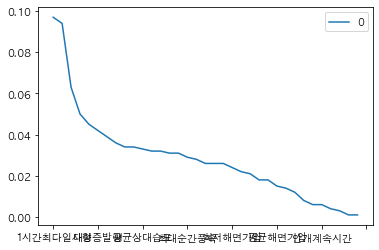

In [325]:
ftres = wth_alm.drop(['n_close', 'Close_x', 'Volume_x', 'Change_x','cd','Volume_y','Change_y', 'Close_y'], axis=1).columns
plt.figure(figsize =(16,8))
pd.DataFrame(np.round(rfr.feature_importances_, 3), index=ftres).sort_values(0, ascending=False).plot(kind='line')
plt.show()

In [292]:
from sklearn.ensemble import RandomForestRegressor

rfr =RandomForestRegressor()
rfr.fit(tr_scaled, y_train)
tr_score= rfr.score(tr_scaled, y_train)
ts_score= rfr.score(ts_scaled, y_test)

print('---------------------------------------------')
print(df_list[0].cd.iloc[0])
print('----------------')
print('gb_score_tr:', rfr.score(tr_scaled, y_train))
print('gb_score_ts:', rfr.score(ts_scaled, y_test))
print('gb_score_pd:', rfr.score(p_scaled, p_target))

print('---------------------------------------------')

---------------------------------------------
120110
----------------
gb_score_tr: 0.9498629339046873
gb_score_ts: 0.5957691537060421
gb_score_pd: -0.9749355444741756
---------------------------------------------


# GradientBoosting
# max_depth =10, n_estimators =200 /0.99/0.72

In [281]:
#종합주가 지수 영향 제거
if (krx[krx['Symbol'] ==df_list[0].cd.iloc[0]].iloc[0,1])=='KOSPI':
    df_list[0]['n_close'] = df_list[0]['Close'] - (df_list[0]['Close']*ks['Change'])
    print('KOSPI')
else :
    df_list[0]['n_close'] = df_list[0]['Close'] - (df_list[0]['Close']*kq['Change'])
    print('KOSDAQ')
    
# 기본 데이터셋 만들기
df_list[0].index = df_list[0].index.astype('datetime64[ns]')
pri_ks = pd.merge(df_list[0], ks, left_index=True, right_index=True)# 코스피+두나무관련주 데이터1번(신성이앤지)
wth_al = pd.merge(wth_df, pri_ks, left_index=True, right_index=True)# 위 데이터+ 날씨

    
# 모델용/ 예측용 구분
wth_alm = wth_al.loc[:'2018-12-31',:].dropna()
wth_alp = wth_al.loc['2019-01-04':,:]

# target/test 구분
target = wth_alm['n_close'].to_numpy()
data = wth_alm.drop(['n_close', 'Close_x', 'Volume_x', 'Change_x','cd','Volume_y','Change_y'], axis=1).to_numpy()

p_target = wth_alp['n_close'].to_numpy()
p_data = wth_alp.drop(['n_close', 'Close_x', 'Volume_x', 'Change_x','cd','Volume_y','Change_y'], axis=1).to_numpy()

from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(data, target, test_size=0.2, random_state=42)

# 표준화
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()
ss.fit(x_train)
tr_scaled =ss.transform(x_train)
ts_scaled =ss.transform(x_test)
p_scaled = ss.transform(p_data)

from sklearn.ensemble import GradientBoostingRegressor
gb = GradientBoostingRegressor(max_depth=10,random_state=42, n_estimators =120)
gb.fit(tr_scaled, y_train)


print('---------------------------------------------')
print(df_list[j].cd.iloc[0])
print('----------------')
print('gb_score_tr:', gb.score(tr_scaled, y_train))
print('gb_score_ts:', gb.score(ts_scaled, y_test))
print('gb_score_pd:', gb.score(p_scaled, p_target))

print('---------------------------------------------')

<ipython-input-281-c083622ff8de>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_list[0]['n_close'] = df_list[0]['Close'] - (df_list[0]['Close']*ks['Change'])


KOSPI
---------------------------------------------
120110
----------------
gb_score_tr: 0.9981436062316954
gb_score_ts: 0.7249907298650877
gb_score_pd: -1.8253362978340357
---------------------------------------------


In [282]:
#종합주가 지수 영향 제거
if (krx[krx['Symbol'] ==df_list[0].cd.iloc[0]].iloc[0,1])=='KOSPI':
    df_list[0]['n_close'] = df_list[0]['Close'] - (df_list[0]['Close']*ks['Change'])
    print('KOSPI')
else :
    df_list[0]['n_close'] = df_list[0]['Close'] - (df_list[0]['Close']*kq['Change'])
    print('KOSDAQ')
    
# 기본 데이터셋 만들기
df_list[0].index = df_list[0].index.astype('datetime64[ns]')
pri_ks = pd.merge(df_list[0], ks, left_index=True, right_index=True)# 코스피+두나무관련주 데이터1번(신성이앤지)
wth_al = pd.merge(wth_df, pri_ks, left_index=True, right_index=True)# 위 데이터+ 날씨

    
# 모델용/ 예측용 구분
wth_alm = wth_al.loc[:'2018-12-31',:].dropna()
wth_alp = wth_al.loc['2019-01-04':,:]

# target/test 구분
target = wth_alm['n_close'].to_numpy()
data = wth_alm.drop(['n_close', 'Close_x', 'Volume_x', 'Change_x','cd','Volume_y','Change_y'], axis=1).to_numpy()

p_target = wth_alp['n_close'].to_numpy()
p_data = wth_alp.drop(['n_close', 'Close_x', 'Volume_x', 'Change_x','cd','Volume_y','Change_y'], axis=1).to_numpy()

from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(data, target, test_size=0.2, random_state=42)

# 표준화
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()
ss.fit(x_train)
tr_scaled =ss.transform(x_train)
ts_scaled =ss.transform(x_test)
p_scaled = ss.transform(p_data)

from sklearn.ensemble import GradientBoostingRegressor
gb = GradientBoostingRegressor(max_depth=5,random_state=42, n_estimators =200)
gb.fit(tr_scaled, y_train)


print('---------------------------------------------')
print(df_list[j].cd.iloc[0])
print('----------------')
print('gb_score_tr:', gb.score(tr_scaled, y_train))
print('gb_score_ts:', gb.score(ts_scaled, y_test))
print('gb_score_pd:', gb.score(p_scaled, p_target))

print('---------------------------------------------')

<ipython-input-282-3c42aa6d57e5>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_list[0]['n_close'] = df_list[0]['Close'] - (df_list[0]['Close']*ks['Change'])


KOSPI
---------------------------------------------
120110
----------------
gb_score_tr: 0.9057852753392365
gb_score_ts: 0.6379228417762243
gb_score_pd: -2.028327265365821
---------------------------------------------


In [ ]:
# GradientBoosting
# max_depth =10, n_estimators =200 /0.99/0.72

In [283]:
#종합주가 지수 영향 제거
if (krx[krx['Symbol'] ==df_list[0].cd.iloc[0]].iloc[0,1])=='KOSPI':
    df_list[0]['n_close'] = df_list[0]['Close'] - (df_list[0]['Close']*ks['Change'])
    print('KOSPI')
else :
    df_list[0]['n_close'] = df_list[0]['Close'] - (df_list[0]['Close']*kq['Change'])
    print('KOSDAQ')
    
# 기본 데이터셋 만들기
df_list[0].index = df_list[0].index.astype('datetime64[ns]')
pri_ks = pd.merge(df_list[0], ks, left_index=True, right_index=True)# 코스피+두나무관련주 데이터1번(신성이앤지)
wth_al = pd.merge(wth_df, pri_ks, left_index=True, right_index=True)# 위 데이터+ 날씨

    
# 모델용/ 예측용 구분
wth_alm = wth_al.loc[:'2018-12-31',:].dropna()
wth_alp = wth_al.loc['2019-01-04':,:]

# target/test 구분
target = wth_alm['n_close'].to_numpy()
data = wth_alm.drop(['n_close', 'Close_x', 'Volume_x', 'Change_x','cd','Volume_y','Change_y'], axis=1).to_numpy()

p_target = wth_alp['n_close'].to_numpy()
p_data = wth_alp.drop(['n_close', 'Close_x', 'Volume_x', 'Change_x','cd','Volume_y','Change_y'], axis=1).to_numpy()

from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(data, target, test_size=0.2, random_state=42)

# 표준화
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()
ss.fit(x_train)
tr_scaled =ss.transform(x_train)
ts_scaled =ss.transform(x_test)
p_scaled = ss.transform(p_data)

from sklearn.ensemble import GradientBoostingRegressor
gb = GradientBoostingRegressor(max_depth=10,random_state=42, n_estimators =200)
gb.fit(tr_scaled, y_train)


print('---------------------------------------------')
print(df_list[j].cd.iloc[0])
print('----------------')
print('gb_score_tr:', gb.score(tr_scaled, y_train))
print('gb_score_ts:', gb.score(ts_scaled, y_test))
print('gb_score_pd:', gb.score(p_scaled, p_target))

print('---------------------------------------------')

<ipython-input-283-8bd818c748d3>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_list[0]['n_close'] = df_list[0]['Close'] - (df_list[0]['Close']*ks['Change'])


KOSPI
---------------------------------------------
120110
----------------
gb_score_tr: 0.999866606687845
gb_score_ts: 0.7262572760892982
gb_score_pd: -1.8320401172202203
---------------------------------------------


In [284]:
#종합주가 지수 영향 제거
if (krx[krx['Symbol'] ==df_list[0].cd.iloc[0]].iloc[0,1])=='KOSPI':
    df_list[0]['n_close'] = df_list[0]['Close'] - (df_list[0]['Close']*ks['Change'])
    print('KOSPI')
else :
    df_list[0]['n_close'] = df_list[0]['Close'] - (df_list[0]['Close']*kq['Change'])
    print('KOSDAQ')
    
# 기본 데이터셋 만들기
df_list[0].index = df_list[0].index.astype('datetime64[ns]')
pri_ks = pd.merge(df_list[0], ks, left_index=True, right_index=True)# 코스피+두나무관련주 데이터1번(신성이앤지)
wth_al = pd.merge(wth_df, pri_ks, left_index=True, right_index=True)# 위 데이터+ 날씨

    
# 모델용/ 예측용 구분
wth_alm = wth_al.loc[:'2018-12-31',:].dropna()
wth_alp = wth_al.loc['2019-01-04':,:]

# target/test 구분
target = wth_alm['n_close'].to_numpy()
data = wth_alm.drop(['n_close', 'Close_x', 'Volume_x', 'Change_x','cd','Volume_y','Change_y'], axis=1).to_numpy()

p_target = wth_alp['n_close'].to_numpy()
p_data = wth_alp.drop(['n_close', 'Close_x', 'Volume_x', 'Change_x','cd','Volume_y','Change_y'], axis=1).to_numpy()

from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(data, target, test_size=0.2, random_state=42)

# 표준화
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()
ss.fit(x_train)
tr_scaled =ss.transform(x_train)
ts_scaled =ss.transform(x_test)
p_scaled = ss.transform(p_data)

from sklearn.ensemble import GradientBoostingRegressor
gb = GradientBoostingRegressor(max_depth=5,random_state=42, n_estimators =400)
gb.fit(tr_scaled, y_train)


print('---------------------------------------------')
print(df_list[j].cd.iloc[0])
print('----------------')
print('gb_score_tr:', gb.score(tr_scaled, y_train))
print('gb_score_ts:', gb.score(ts_scaled, y_test))
print('gb_score_pd:', gb.score(p_scaled, p_target))

print('---------------------------------------------')

<ipython-input-284-0af839a49a9b>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_list[0]['n_close'] = df_list[0]['Close'] - (df_list[0]['Close']*ks['Change'])


KOSPI
---------------------------------------------
120110
----------------
gb_score_tr: 0.9704733596818408
gb_score_ts: 0.6557261646787143
gb_score_pd: -2.1669833479787104
---------------------------------------------


In [284]:
#종합주가 지수 영향 제거
if (krx[krx['Symbol'] ==df_list[0].cd.iloc[0]].iloc[0,1])=='KOSPI':
    df_list[0]['n_close'] = df_list[0]['Close'] - (df_list[0]['Close']*ks['Change'])
    print('KOSPI')
else :
    df_list[0]['n_close'] = df_list[0]['Close'] - (df_list[0]['Close']*kq['Change'])
    print('KOSDAQ')
    
# 기본 데이터셋 만들기
df_list[0].index = df_list[0].index.astype('datetime64[ns]')
pri_ks = pd.merge(df_list[0], ks, left_index=True, right_index=True)# 코스피+두나무관련주 데이터1번(신성이앤지)
wth_al = pd.merge(wth_df, pri_ks, left_index=True, right_index=True)# 위 데이터+ 날씨

    
# 모델용/ 예측용 구분
wth_alm = wth_al.loc[:'2018-12-31',:].dropna()
wth_alp = wth_al.loc['2019-01-04':,:]

# target/test 구분
target = wth_alm['n_close'].to_numpy()
data = wth_alm.drop(['n_close', 'Close_x', 'Volume_x', 'Change_x','cd','Volume_y','Change_y'], axis=1).to_numpy()

p_target = wth_alp['n_close'].to_numpy()
p_data = wth_alp.drop(['n_close', 'Close_x', 'Volume_x', 'Change_x','cd','Volume_y','Change_y'], axis=1).to_numpy()

from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(data, target, test_size=0.2, random_state=42)

# 표준화
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()
ss.fit(x_train)
tr_scaled =ss.transform(x_train)
ts_scaled =ss.transform(x_test)
p_scaled = ss.transform(p_data)

from sklearn.ensemble import GradientBoostingRegressor
gb = GradientBoostingRegressor(max_depth=5,random_state=42, n_estimators =400)
gb.fit(tr_scaled, y_train)


print('---------------------------------------------')
print(df_list[j].cd.iloc[0])
print('----------------')
print('gb_score_tr:', gb.score(tr_scaled, y_train))
print('gb_score_ts:', gb.score(ts_scaled, y_test))
print('gb_score_pd:', gb.score(p_scaled, p_target))

print('---------------------------------------------')

<ipython-input-284-0af839a49a9b>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_list[0]['n_close'] = df_list[0]['Close'] - (df_list[0]['Close']*ks['Change'])


KOSPI
---------------------------------------------
120110
----------------
gb_score_tr: 0.9704733596818408
gb_score_ts: 0.6557261646787143
gb_score_pd: -2.1669833479787104
---------------------------------------------


In [285]:
#종합주가 지수 영향 제거
if (krx[krx['Symbol'] ==df_list[0].cd.iloc[0]].iloc[0,1])=='KOSPI':
    df_list[0]['n_close'] = df_list[0]['Close'] - (df_list[0]['Close']*ks['Change'])
    print('KOSPI')
else :
    df_list[0]['n_close'] = df_list[0]['Close'] - (df_list[0]['Close']*kq['Change'])
    print('KOSDAQ')
    
# 기본 데이터셋 만들기
df_list[0].index = df_list[0].index.astype('datetime64[ns]')
pri_ks = pd.merge(df_list[0], ks, left_index=True, right_index=True)# 코스피+두나무관련주 데이터1번(신성이앤지)
wth_al = pd.merge(wth_df, pri_ks, left_index=True, right_index=True)# 위 데이터+ 날씨

    
# 모델용/ 예측용 구분
wth_alm = wth_al.loc[:'2018-12-31',:].dropna()
wth_alp = wth_al.loc['2019-01-04':,:]

# target/test 구분
target = wth_alm['n_close'].to_numpy()
data = wth_alm.drop(['n_close', 'Close_x', 'Volume_x', 'Change_x','cd','Volume_y','Change_y'], axis=1).to_numpy()

p_target = wth_alp['n_close'].to_numpy()
p_data = wth_alp.drop(['n_close', 'Close_x', 'Volume_x', 'Change_x','cd','Volume_y','Change_y'], axis=1).to_numpy()

from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(data, target, test_size=0.2, random_state=42)

# 표준화
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()
ss.fit(x_train)
tr_scaled =ss.transform(x_train)
ts_scaled =ss.transform(x_test)
p_scaled = ss.transform(p_data)

from sklearn.ensemble import GradientBoostingRegressor
gb = GradientBoostingRegressor(max_depth=5,random_state=42, n_estimators =400, learning_rate =1)
gb.fit(tr_scaled, y_train)


print('---------------------------------------------')
print(df_list[j].cd.iloc[0])
print('----------------')
print('gb_score_tr:', gb.score(tr_scaled, y_train))
print('gb_score_ts:', gb.score(ts_scaled, y_test))
print('gb_score_pd:', gb.score(p_scaled, p_target))

print('---------------------------------------------')

<ipython-input-285-454f3560168c>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_list[0]['n_close'] = df_list[0]['Close'] - (df_list[0]['Close']*ks['Change'])


KOSPI
---------------------------------------------
120110
----------------
gb_score_tr: 0.9999998005604183
gb_score_ts: 0.2545391704278023
gb_score_pd: -5.8772364095869705
---------------------------------------------


In [286]:
#종합주가 지수 영향 제거
if (krx[krx['Symbol'] ==df_list[0].cd.iloc[0]].iloc[0,1])=='KOSPI':
    df_list[0]['n_close'] = df_list[0]['Close'] - (df_list[0]['Close']*ks['Change'])
    print('KOSPI')
else :
    df_list[0]['n_close'] = df_list[0]['Close'] - (df_list[0]['Close']*kq['Change'])
    print('KOSDAQ')
    
# 기본 데이터셋 만들기
df_list[0].index = df_list[0].index.astype('datetime64[ns]')
pri_ks = pd.merge(df_list[0], ks, left_index=True, right_index=True)# 코스피+두나무관련주 데이터1번(신성이앤지)
wth_al = pd.merge(wth_df, pri_ks, left_index=True, right_index=True)# 위 데이터+ 날씨

    
# 모델용/ 예측용 구분
wth_alm = wth_al.loc[:'2018-12-31',:].dropna()
wth_alp = wth_al.loc['2019-01-04':,:]

# target/test 구분
target = wth_alm['n_close'].to_numpy()
data = wth_alm.drop(['n_close', 'Close_x', 'Volume_x', 'Change_x','cd','Volume_y','Change_y'], axis=1).to_numpy()

p_target = wth_alp['n_close'].to_numpy()
p_data = wth_alp.drop(['n_close', 'Close_x', 'Volume_x', 'Change_x','cd','Volume_y','Change_y'], axis=1).to_numpy()

from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(data, target, test_size=0.2, random_state=42)

# 표준화
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()
ss.fit(x_train)
tr_scaled =ss.transform(x_train)
ts_scaled =ss.transform(x_test)
p_scaled = ss.transform(p_data)

from sklearn.ensemble import GradientBoostingRegressor
gb = GradientBoostingRegressor(max_depth=5,random_state=42, n_estimators =400, learning_rate =0.01)
gb.fit(tr_scaled, y_train)


print('---------------------------------------------')
print(df_list[j].cd.iloc[0])
print('----------------')
print('gb_score_tr:', gb.score(tr_scaled, y_train))
print('gb_score_ts:', gb.score(ts_scaled, y_test))
print('gb_score_pd:', gb.score(p_scaled, p_target))

print('---------------------------------------------')

<ipython-input-286-3c059b822396>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_list[0]['n_close'] = df_list[0]['Close'] - (df_list[0]['Close']*ks['Change'])


KOSPI
---------------------------------------------
120110
----------------
gb_score_tr: 0.6902026185432832
gb_score_ts: 0.5779786899826118
gb_score_pd: -1.6398516605542475
---------------------------------------------


In [ ]:
# n_estimator

In [ ]:
# n_estimator

In [274]:
for j in range(len(df_list)) : 
    df_list[j].index = df_list[j].index.astype('datetime64[ns]')
    df_list[j].fillna(0)
    
    #종합주가 지수 영향 제거
    if (krx[krx['Symbol'] ==df_list[j].cd.iloc[0]].iloc[0,1])=='KOSPI':
        df_list[j]['n_close'] = df_list[j]['Close'] - (df_list[j]['Close']*ks['Change'])
        print('KOSPI')
    else :
        df_list[j]['n_close'] = df_list[j]['Close'] - (df_list[j]['Close']*kq['Change'])
        print('KOSDAQ')
    
        # 기본 데이터셋 만들기
    df_list[j].index = df_list[j].index.astype('datetime64[ns]')
    pri_ks = pd.merge(df_list[j], ks, left_index=True, right_index=True)# 코스피+두나무관련주 데이터1번(신성이앤지)
    wth_al = pd.merge(wth_df, pri_ks, left_index=True, right_index=True)# 위 데이터+ 날씨
    
    
    # 모델용/ 예측용 구분
    wth_alm = wth_al.loc[:'2018-12-31',:].dropna()
    wth_alp = wth_al.loc['2019-01-04':,:]

    # target/test 구분
    target = wth_alm['n_close'].to_numpy()
    data = wth_alm.drop(['n_close', 'Close_x', 'Volume_x', 'Change_x','cd','Volume_y','Change_y'], axis=1).to_numpy()

    p_target = wth_alp['n_close'].to_numpy()
    p_data = wth_alp.drop(['n_close', 'Close_x', 'Volume_x', 'Change_x','cd','Volume_y','Change_y'], axis=1).to_numpy()

    from sklearn.model_selection import train_test_split
    x_train, x_test, y_train, y_test = train_test_split(data, target, test_size=0.2, random_state=42)

    # 표준화
    from sklearn.preprocessing import StandardScaler
    ss = StandardScaler()
    ss.fit(x_train)
    tr_scaled =ss.transform(x_train)
    ts_scaled =ss.transform(x_test)
    p_scaled = ss.transform(p_data)

    # 모델 구축

    from sklearn.ensemble import RandomForestRegressor

    rfr =RandomForestRegressor(n_estimators=50)
    rfr.fit(tr_scaled, y_train)

#    print(krx[krx['Symbol']==df_list[j].cd.iloc[0]].Name)
    print(df_list[j].cd.iloc[0])
    print('----------------')
    print('rfr_score_tr:', rfr.score(tr_scaled, y_train))
    print('rfr_score_ts:', rfr.score(ts_scaled, y_test))
    print('rfr_score_pd:', rfr.score(p_scaled, p_target))

    print('---------------------------------------------')

<ipython-input-274-ba58f2e83cd6>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_list[j]['n_close'] = df_list[j]['Close'] - (df_list[j]['Close']*ks['Change'])


KOSPI
011930
----------------
rfr_score_tr: 0.9533320333729453
rfr_score_ts: 0.6853811384470135
rfr_score_pd: -1.5053599103794322
---------------------------------------------
KOSDAQ


<ipython-input-274-ba58f2e83cd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_list[j]['n_close'] = df_list[j]['Close'] - (df_list[j]['Close']*kq['Change'])


246690
----------------
rfr_score_tr: 0.9824007268040593
rfr_score_ts: 0.8582022295868541
rfr_score_pd: -0.09243215927057702
---------------------------------------------
KOSDAQ


<ipython-input-274-ba58f2e83cd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_list[j]['n_close'] = df_list[j]['Close'] - (df_list[j]['Close']*kq['Change'])


041190
----------------
rfr_score_tr: 0.9892436889672284
rfr_score_ts: 0.9412418353620684
rfr_score_pd: -0.8067263132028386
---------------------------------------------
KOSDAQ


<ipython-input-274-ba58f2e83cd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_list[j]['n_close'] = df_list[j]['Close'] - (df_list[j]['Close']*kq['Change'])


018700
----------------
rfr_score_tr: 0.9815848654948616
rfr_score_ts: 0.8426583273327541
rfr_score_pd: -43.25600956555935
---------------------------------------------
KOSDAQ


<ipython-input-274-ba58f2e83cd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_list[j]['n_close'] = df_list[j]['Close'] - (df_list[j]['Close']*kq['Change'])


021080
----------------
rfr_score_tr: 0.9828142445299463
rfr_score_ts: 0.8859144910096267
rfr_score_pd: -0.21104317922374038
---------------------------------------------
KOSDAQ


<ipython-input-274-ba58f2e83cd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_list[j]['n_close'] = df_list[j]['Close'] - (df_list[j]['Close']*kq['Change'])


027830
----------------
rfr_score_tr: 0.9762493627160287
rfr_score_ts: 0.8349918703339961
rfr_score_pd: -0.055823921180725655
---------------------------------------------
KOSPI


<ipython-input-274-ba58f2e83cd6>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_list[j]['n_close'] = df_list[j]['Close'] - (df_list[j]['Close']*ks['Change'])


003530
----------------
rfr_score_tr: 0.9496965938429813
rfr_score_ts: 0.6071810323546317
rfr_score_pd: -2.6816692019492456
---------------------------------------------
KOSDAQ


<ipython-input-274-ba58f2e83cd6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_list[j]['n_close'] = df_list[j]['Close'] - (df_list[j]['Close']*kq['Change'])


241520
----------------
rfr_score_tr: 0.9808193279081179
rfr_score_ts: 0.8741723715281998
rfr_score_pd: 0.14594874144009085
---------------------------------------------
KOSPI


<ipython-input-274-ba58f2e83cd6>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_list[j]['n_close'] = df_list[j]['Close'] - (df_list[j]['Close']*ks['Change'])


035720
----------------
rfr_score_tr: 0.9829487227524626
rfr_score_ts: 0.9071889630635784
rfr_score_pd: -0.8687323321453704
---------------------------------------------
KOSPI


<ipython-input-274-ba58f2e83cd6>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_list[j]['n_close'] = df_list[j]['Close'] - (df_list[j]['Close']*ks['Change'])


002020
----------------
rfr_score_tr: 0.9713853666423138
rfr_score_ts: 0.8351255510845964
rfr_score_pd: -18.05053857074768
---------------------------------------------
KOSPI


<ipython-input-274-ba58f2e83cd6>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_list[j]['n_close'] = df_list[j]['Close'] - (df_list[j]['Close']*ks['Change'])


KeyboardInterrupt: 

In [276]:
for j in range(len(df_list)) : 
    df_list[j].index = df_list[j].index.astype('datetime64[ns]')
    df_list[j].fillna(0)
    
    #종합주가 지수 영향 제거
    if (krx[krx['Symbol'] ==df_list[j].cd.iloc[0]].iloc[0,1])=='KOSPI':
        df_list[j]['n_close'] = df_list[j]['Close'] - (df_list[j]['Close']*ks['Change'])
        print('KOSPI')
    else :
        df_list[j]['n_close'] = df_list[j]['Close'] - (df_list[j]['Close']*kq['Change'])
        print('KOSDAQ')
    
        # 기본 데이터셋 만들기
    df_list[j].index = df_list[j].index.astype('datetime64[ns]')
    pri_ks = pd.merge(df_list[j], ks, left_index=True, right_index=True)# 코스피+두나무관련주 데이터1번(신성이앤지)
    wth_al = pd.merge(wth_df, pri_ks, left_index=True, right_index=True)# 위 데이터+ 날씨
    
    
    # 모델용/ 예측용 구분
    wth_alm = wth_al.loc[:'2018-12-31',:].dropna()
    wth_alp = wth_al.loc['2019-01-04':,:]

    # target/test 구분
    target = wth_alm['n_close'].to_numpy()
    data = wth_alm.drop(['n_close', 'Close_x', 'Volume_x', 'Change_x','cd','Volume_y','Change_y'], axis=1).to_numpy()

    p_target = wth_alp['n_close'].to_numpy()
    p_data = wth_alp.drop(['n_close', 'Close_x', 'Volume_x', 'Change_x','cd','Volume_y','Change_y'], axis=1).to_numpy()

    from sklearn.model_selection import train_test_split
    x_train, x_test, y_train, y_test = train_test_split(data, target, test_size=0.2, random_state=42)

    # 표준화
    from sklearn.preprocessing import StandardScaler
    ss = StandardScaler()
    ss.fit(x_train)
    tr_scaled =ss.transform(x_train)
    ts_scaled =ss.transform(x_test)
    p_scaled = ss.transform(p_data)

    # 모델 구축

    from sklearn.ensemble import RandomForestRegressor

    rfr =RandomForestRegressor(n_estimators=300)
    rfr.fit(tr_scaled, y_train)

#    print(krx[krx['Symbol']==df_list[j].cd.iloc[0]].Name)
    print(df_list[j].cd.iloc[0])
    print('----------------')
    print('rfr_score_tr:', rfr.score(tr_scaled, y_train))
    print('rfr_score_ts:', rfr.score(ts_scaled, y_test))
    print('rfr_score_pd:', rfr.score(p_scaled, p_target))

    print('---------------------------------------------')

<ipython-input-276-4d2e62344858>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_list[j]['n_close'] = df_list[j]['Close'] - (df_list[j]['Close']*ks['Change'])


KOSPI
011930
----------------
rfr_score_tr: 0.9582988790458177
rfr_score_ts: 0.7061088280092909
rfr_score_pd: -1.4365302908500373
---------------------------------------------
KOSDAQ


<ipython-input-276-4d2e62344858>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_list[j]['n_close'] = df_list[j]['Close'] - (df_list[j]['Close']*kq['Change'])


246690
----------------
rfr_score_tr: 0.9833669417549329
rfr_score_ts: 0.8581114848644537
rfr_score_pd: -0.08734877958200915
---------------------------------------------
KOSDAQ


<ipython-input-276-4d2e62344858>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_list[j]['n_close'] = df_list[j]['Close'] - (df_list[j]['Close']*kq['Change'])


041190
----------------
rfr_score_tr: 0.989346674110288
rfr_score_ts: 0.9392586792677489
rfr_score_pd: -0.7945672533302315
---------------------------------------------
KOSDAQ


<ipython-input-276-4d2e62344858>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_list[j]['n_close'] = df_list[j]['Close'] - (df_list[j]['Close']*kq['Change'])


018700
----------------
rfr_score_tr: 0.9820733320696015
rfr_score_ts: 0.8470939882155686
rfr_score_pd: -43.951113989581195
---------------------------------------------
KOSDAQ


<ipython-input-276-4d2e62344858>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_list[j]['n_close'] = df_list[j]['Close'] - (df_list[j]['Close']*kq['Change'])


021080
----------------
rfr_score_tr: 0.9847584422104827
rfr_score_ts: 0.8938084272932588
rfr_score_pd: -0.19465830423503494
---------------------------------------------
KOSDAQ


<ipython-input-276-4d2e62344858>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_list[j]['n_close'] = df_list[j]['Close'] - (df_list[j]['Close']*kq['Change'])


027830
----------------
rfr_score_tr: 0.9780404053899949
rfr_score_ts: 0.8438541176602288
rfr_score_pd: -0.055690354921614116
---------------------------------------------
KOSPI


<ipython-input-276-4d2e62344858>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_list[j]['n_close'] = df_list[j]['Close'] - (df_list[j]['Close']*ks['Change'])


003530
----------------
rfr_score_tr: 0.9532573922433396
rfr_score_ts: 0.6306174894509307
rfr_score_pd: -2.523066914153947
---------------------------------------------
KOSDAQ


<ipython-input-276-4d2e62344858>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_list[j]['n_close'] = df_list[j]['Close'] - (df_list[j]['Close']*kq['Change'])


241520
----------------
rfr_score_tr: 0.9825051739800382
rfr_score_ts: 0.8774228074854864
rfr_score_pd: 0.14711215469318473
---------------------------------------------
KOSPI


<ipython-input-276-4d2e62344858>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_list[j]['n_close'] = df_list[j]['Close'] - (df_list[j]['Close']*ks['Change'])


035720
----------------
rfr_score_tr: 0.9848819011001156
rfr_score_ts: 0.9111638168610702
rfr_score_pd: -0.86681174045663
---------------------------------------------
KOSPI


<ipython-input-276-4d2e62344858>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_list[j]['n_close'] = df_list[j]['Close'] - (df_list[j]['Close']*ks['Change'])


002020
----------------
rfr_score_tr: 0.9748058750027006
rfr_score_ts: 0.8390533262413751
rfr_score_pd: -18.179988882760114
---------------------------------------------
KOSPI


<ipython-input-276-4d2e62344858>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_list[j]['n_close'] = df_list[j]['Close'] - (df_list[j]['Close']*ks['Change'])


KeyboardInterrupt: 

In [218]:
krx.head()

,Symbol,Market,Name,Sector,Industry,ListingDate,SettleMonth,Representative,HomePage,Region
0,060310,KOSDAQ,3S,전자부품 제조업,반도체 웨이퍼 캐리어,2002-04-23,03월,"박종익, 김세완 (각자 대표이사)",http://www.3sref.com,서울특별시
1,095570,KOSPI,AJ네트웍스,산업용 기계 및 장비 임대업,"렌탈(파렛트, OA장비, 건설장비)",2015-08-21,12월,박대현,http://www.ajnet.co.kr,서울특별시
2,006840,KOSPI,AK홀딩스,기타 금융업,지주사업,1999-08-11,12월,"채형석, 이석주(각자 대표이사)",http://www.aekyunggroup.co.kr,서울특별시
3,054620,KOSDAQ,APS홀딩스,기타 금융업,인터넷 트래픽 솔루션,2001-12-04,12월,정기로,http://www.apsholdings.co.kr,경기도
4,265520,KOSDAQ,AP시스템,특수 목적용 기계 제조업,디스플레이 제조 장비,2017-04-07,12월,김영주,http://www.apsystems.co.kr,경기도


In [225]:
krx[krx['Symbol']==df_list[0].cd.iloc[0]].Name

3930    신성이엔지
Name: Name, dtype: object

In [227]:
ks.head()

,Close,Volume,Change
Date,,,
2000-01-04,1059.04,195900000.0,0.0301
2000-01-05,986.31,257700000.0,-0.0687
2000-01-06,960.79,203520000.0,-0.0259
2000-01-07,948.65,215660000.0,-0.0126
2000-01-10,987.24,240180000.0,0.0407


In [226]:
# 종합주가 지수 데이터프레임 파일 구축
import FinanceDataReader as fdr
ks = fdr.DataReader('KS11', '2000').dropna() 
ks.drop(['Open', 'High', 'Low'], axis =1, inplace = True)
kq= fdr.DataReader('KQ11','2000').dropna()
ks.drop(['Open', 'High', 'Low'], axis =1, inplace= True)
krx = fdr.StockListing('KRX')


#종합주가 지수 영향 제거
if (krx[krx['Symbol'] ==df_list[0].cd.iloc[0]].iloc[0,1])=='KOSPI':
    df_list[0]['n_close'] = df_list[0]['Close'] - (df_list[0]['Close']*ks['Change'])
    print('KOSPI')
else :
    df_list[0]['n_close'] = df_list[0]['Close'] - (df_list[0]['Close']*kq['Change'])
    print('KOSDAQ')
    
# 기본 데이터셋 만들기
df_list[0].index = df_list[0].index.astype('datetime64[ns]')
pri_ks = pd.merge(df_list[0], ks, left_index=True, right_index=True)# 코스피+두나무관련주 데이터1번(신성이앤지)
wth_al = pd.merge(wth_df, pri_ks, left_index=True, right_index=True)# 위 데이터+ 날씨

# 모델용/ 예측용 구분
wth_alm = wth_al.loc[:'2019-12-31',:]
wth_alp = wth_al.loc['2020-01-04':,:]

# target/test 구분
target = wth_alm['n_close'].to_numpy()
data = wth_alm.drop(['n_close', 'Close_x', 'Volume_x', 'Change_x','cd','Volume_y','Change_y'], axis=1).to_numpy()

p_target = wth_alp['n_close'].to_numpy()
p_data = wth_alp.drop(['n_close', 'Close_x', 'Volume_x', 'Change_x','cd','Volume_y','Change_y'], axis=1).to_numpy()

from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(data, target, test_size=0.2, random_state=42)

# 표준화
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()
ss.fit(x_train)
tr_scaled =ss.transform(x_train)
ts_scaled =ss.transform(x_test)
p_scaled = ss.transform(p_data)

# 모델 구축
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
lr=LinearRegression()
kreg = KNeighborsRegressor()
rfr =RandomForestRegressor()

lr.fit(tr_scaled, y_train)
kreg.fit(tr_scaled, y_train)
rfr.fit(tr_scaled, y_train)

print(krx[krx['Symbol']==df_list[0].cd.iloc[0]].Name)

print('lr_score:', lr.score(tr_scaled, y_train))
print('lr_score_ts:', lr.score(ts_scaled, y_test))
print('lr_score_ts:', lr.score(ts_scaled, y_test))
print('lr_score_pd:', lr.score(p_scaled, p_target))

print('----------------')
print('kr_score:', kreg.score(tr_scaled, y_train))
print('kr_score_ts:', kreg.score(ts_scaled, y_test))
print('kr_score_pd:', kreg.score(p_scaled, p_target))

print('----------------')
print('rfr_score:', rfr.score(tr_scaled, y_train))
print('rfr_score_ts:', rfr.score(ts_scaled, y_test))
print('rfr_score_pd:', rfr.score(p_scaled, p_target))

print('---------------------------------------------')

KeyError: "['Open' 'High' 'Low'] not found in axis"

In [214]:
df_list[0].cd.iloc[0]

'011930'

In [211]:
target = wth_alm['n_close'].to_numpy()
data = wth_alm.drop(['n_close', 'Close_x', 'Volume_x', 'Change_x','cd','Volume_y','Change_y'], axis=1).to_numpy()

In [212]:
print(target.shape)
print(data.shape)

(4936,)
(4936, 39)


In [213]:
wth_alp.shape

(443, 46)

In [ ]:
da

In [192]:
import datetime

In [208]:
wth_alm = wth_al.loc[:'2019-12-31',:]
wth_alm.head()

,평균기온,최저기온,최고기온,강수계속시간,10분최다강수,1시간최다강수,일강수,최대순간풍속,최대풍속,평균풍속,...,Volume_x,Change_x,cd,n_close,Close_y,Open,High,Low,Volume_y,Change_y
2000-01-04,0.3,-4.3,4.3,0.00,0.0,0.0,0.0,4.5,3.0,1.7,...,830800,0.149385,011930,7246.1229,1059.04,1028.33,1066.18,1016.59,195900000.0,0.0301
2000-01-05,2.8,0.1,4.6,13.90,0.0,0.0,18.4,9.1,5.2,3.2,...,593940,-0.053942,011930,7553.5716,986.31,1006.87,1026.52,984.05,257700000.0,-0.0687
2000-01-06,1.7,-4.2,5.7,6.08,0.0,0.0,9.8,11.1,6.9,3.5,...,563820,-0.050651,011930,6883.7890,960.79,1013.95,1014.90,953.50,203520000.0,-0.0259
2000-01-07,-8.2,-12.1,-4.2,1.50,0.0,0.0,0.0,12.3,7.2,2.5,...,529110,-0.004024,011930,6767.2058,948.65,949.17,970.16,930.84,215660000.0,-0.0126
2000-01-10,-0.8,-4.8,2.3,1.83,0.0,0.0,0.1,8.8,5.5,2.8,...,531610,0.008230,011930,6463.7634,987.24,979.67,994.94,965.02,240180000.0,0.0407


In [209]:
wth_alp=wth_al.loc['2020-01-04':,:]
wth_alp.head()

,평균기온,최저기온,최고기온,강수계속시간,10분최다강수,1시간최다강수,일강수,최대순간풍속,최대풍속,평균풍속,...,Volume_x,Change_x,cd,n_close,Close_y,Open,High,Low,Volume_y,Change_y
2020-01-06,3.1,0.6,4.6,14.33,0.0,0.0,1.8,8.8,5.4,3.1,...,478131,-0.023013,011930,943.1532,2155.07,2154.97,2164.42,2149.95,592670000.0,-0.0098
2020-01-07,6.3,4.2,7.7,24.00,0.0,0.0,46.3,9.5,6.3,4.0,...,307585,0.011777,011930,936.0225,2175.54,2166.60,2181.62,2164.27,568240000.0,0.0095
2020-01-08,2.4,-0.4,8.9,9.50,0.0,0.0,11.6,11.8,6.3,3.3,...,1796276,-0.023280,011930,933.2453,2151.31,2156.27,2162.32,2137.72,913830000.0,-0.0111
2020-01-09,-1.2,-3.1,2.0,0.00,0.0,0.0,0.0,7.2,4.3,2.3,...,986105,0.047671,011930,951.2379,2186.45,2182.20,2186.45,2172.16,592600000.0,0.0163
2020-01-10,-0.6,-4.3,4.2,0.00,0.0,0.0,0.0,5.5,3.7,1.5,...,1641276,0.028956,011930,985.9455,2206.39,2189.48,2206.92,2188.10,594540000.0,0.0091


In [184]:
wth_al.head().loc[:'2000-01-02',:]

,평균기온,최저기온,최고기온,강수계속시간,10분최다강수,1시간최다강수,일강수,최대순간풍속,최대풍속,평균풍속,...,Volume_x,Change_x,cd,n_close,Close_y,Open,High,Low,Volume_y,Change_y


In [171]:
target = wth_al['n_close'].to_numpy()
data = wth_al.drop(['n_close', 'Close_x', 'Volume_x', 'Change_x','cd','Volume_y','Change_y'], axis=1).to_numpy()

In [176]:
print(target.shape)
print(data.shape)

(5381,)
(5381, 39)


In [ ]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(data, target, test_size=0.2, random_state=42)

In [169]:
df_list[0].index = df_list[0].index.astype('datetime64[ns]')
pri_ks = pd.merge(df_list[0], ks, left_index=True, right_index=True)# 코스피+두나무관련주 데이터1번(신성이앤지)
wth_al = pd.merge(wth_df, pri_ks, left_index=True, right_index=True)

In [170]:
wth_al

,평균기온,최저기온,최고기온,강수계속시간,10분최다강수,1시간최다강수,일강수,최대순간풍속,최대풍속,평균풍속,...,Volume_x,Change_x,cd,n_close,Close_y,Open,High,Low,Volume_y,Change_y
2000-01-04,0.3,-4.3,4.3,0.00,0.0,0.0,0.0,4.5,3.0,1.7,...,830800,0.149385,011930,7246.1229,1059.04,1028.33,1066.18,1016.59,195900000.0,0.0301
2000-01-05,2.8,0.1,4.6,13.90,0.0,0.0,18.4,9.1,5.2,3.2,...,593940,-0.053942,011930,7553.5716,986.31,1006.87,1026.52,984.05,257700000.0,-0.0687
2000-01-06,1.7,-4.2,5.7,6.08,0.0,0.0,9.8,11.1,6.9,3.5,...,563820,-0.050651,011930,6883.7890,960.79,1013.95,1014.90,953.50,203520000.0,-0.0259
2000-01-07,-8.2,-12.1,-4.2,1.50,0.0,0.0,0.0,12.3,7.2,2.5,...,529110,-0.004024,011930,6767.2058,948.65,949.17,970.16,930.84,215660000.0,-0.0126
2000-01-10,-0.8,-4.8,2.3,1.83,0.0,0.0,0.1,8.8,5.5,2.8,...,531610,0.008230,011930,6463.7634,987.24,979.67,994.94,965.02,240180000.0,0.0407
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-10-14,19.7,17.4,23.9,0.00,0.0,0.0,0.0,6.9,4.2,2.0,...,1233031,0.020408,011930,2216.2500,2988.64,2968.87,2988.97,2962.33,617170000.0,0.0150
2021-10-15,19.0,17.0,21.4,7.83,0.0,0.0,0.0,5.8,3.8,2.1,...,2004812,0.024444,011930,2284.7160,3015.06,3012.62,3021.90,2999.33,857800000.0,0.0088
2021-10-18,9.6,2.8,16.1,4.08,1.3,4.8,5.6,6.2,3.6,2.0,...,1052066,-0.006508,011930,2296.4120,3006.68,3017.48,3021.17,2990.44,926370000.0,-0.0028
2021-10-19,10.9,7.1,15.0,2.75,1.0,3.1,4.4,9.5,5.4,2.4,...,1355218,0.000000,011930,2273.0540,3029.04,3022.23,3034.53,3014.19,845700000.0,0.0074


In [96]:
krx.head(1)

,Symbol,Market,Name,Sector,Industry,ListingDate,SettleMonth,Representative,HomePage,Region
0,060310,KOSDAQ,3S,전자부품 제조업,반도체 웨이퍼 캐리어,2002-04-23,03월,"박종익, 김세완 (각자 대표이사)",http://www.3sref.com,서울특별시


In [98]:
mtype=krx.loc[:,('Symbol', 'Market')]

In [123]:
krx.Market.value_counts()

KOSPI     5269
KOSDAQ    1538
KONEX      133
Name: Market, dtype: int64

In [99]:
mtype.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6940 entries, 0 to 6939
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Symbol  6940 non-null   object
 1   Market  6940 non-null   object
dtypes: object(2)
memory usage: 420.7+ KB


In [110]:
ks.head(1)

,Close,Volume,Change
Date,,,
2000-01-04,1059.04,195900000.0,0.0301


In [33]:
today = pd.datetime.now()
today_str = str(today)[:10].replace('-','')

theme_nm='두나무 관련주'
# path = '{}_list_{}.csv'.format(theme_nm, today_str)
path = '두나무 관련주_list_20211026.csv'

df_theme_code_result = pd.read_csv(path,index_col=0)
df_theme_code_result = df_theme_code_result.set_index(df_theme_code_result['Date'])
df_theme_code_result.drop('Date',axis=1,inplace=True)
df_theme_code_result.cd = df_theme_code_result.cd.apply(lambda x : str(x).zfill(6))

df_list=[]

for i in range(len(df_theme_code_result.cd.unique())) : 
    code = df_theme_code_result.cd.unique()[i]
    df = df_theme_code_result[df_theme_code_result['cd']==code]
    df_list.append(df)

import FinanceDataReader as fdr
ks = fdr.DataReader('KS11', '2000') 
ks.drop(['Open', 'High', 'Low'], axis =1, inplace =True)
    
for j in range(len(df_list)) : 
    df_list[j].index = df_list[j].index.astype('datetime64[ns]')


    # 기본 데이터셋 만들기
    pri_ks = pd.merge(df_list[0], ks, left_index=True, right_index=True)# 코스피+두나무관련주 데이터1번(신성이앤지)
    wth_al = pd.merge(wth_df, pri_ks, left_index=True, right_index=True)# 위 데이터+ 날씨

    # x, y 구분
    target = wth_al['Close_x'].to_numpy()
    data = wth_al.drop(['Close_x', 'Volume_x', 'Change_x','cd','Volume_y','Change_y'], axis=1).to_numpy()
    from sklearn.model_selection import train_test_split
    x_train, x_test, y_train, y_test = train_test_split(data, target, test_size=0.2, random_state=42)

    # 표준화
    from sklearn.preprocessing import StandardScaler
    ss = StandardScaler()
    ss.fit(x_train)
    tr_scaled =ss.transform(x_train)
    ts_scaled =ss.transform(x_test)

    # 모델 구축
    from sklearn.linear_model import LinearRegression
    from sklearn.neighbors import KNeighborsRegressor
    from sklearn.ensemble import RandomForestRegressor
    lr=LinearRegression()
    kreg = KNeighborsRegressor()
    rfr =RandomForestRegressor()

    lr.fit(tr_scaled, y_train)
    kreg.fit(tr_scaled, y_train)
    rfr.fit(tr_scaled, y_train)
    
    print('lr_score:', lr.score(tr_scaled, y_train))
    print('lr_score_ts:', lr.score(ts_scaled, y_test))
    print('----------------')
    print('kr_score:', kreg.score(tr_scaled, y_train))
    print('kr_score_ts:', kreg.score(ts_scaled, y_test))
    print('----------------')
    print('rfr_score:', rfr.score(tr_scaled, y_train))
    print('rfr_score_ts:', rfr.score(ts_scaled, y_test))

<ipython-input-33-7d4e8b3df715>:1: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  today = pd.datetime.now()


lr_score: 0.22475985818695143
lr_score_ts: 0.23919345319091456
----------------
kr_score: 0.4781675964975044
kr_score_ts: 0.22408447186347646
----------------
rfr_score: 0.9572496110460785
rfr_score_ts: 0.727055737904682
lr_score: 0.22475985818695143
lr_score_ts: 0.23919345319091456
----------------
kr_score: 0.4781675964975044
kr_score_ts: 0.22408447186347646
----------------
rfr_score: 0.9573185567476026
rfr_score_ts: 0.7203277233218609
lr_score: 0.22475985818695143
lr_score_ts: 0.23919345319091456
----------------
kr_score: 0.4781675964975044
kr_score_ts: 0.22408447186347646
----------------
rfr_score: 0.9579045260991444
rfr_score_ts: 0.7269196841902847
lr_score: 0.22475985818695143
lr_score_ts: 0.23919345319091456
----------------
kr_score: 0.4781675964975044
kr_score_ts: 0.22408447186347646
----------------
rfr_score: 0.957328194574326
rfr_score_ts: 0.7210023570751168
lr_score: 0.22475985818695143
lr_score_ts: 0.23919345319091456
----------------
kr_score: 0.4781675964975044
kr_sc

In [ ]:
ks = fdr.DataReader('KS11', '2000').dropna() 

In [140]:
ks=ks[:-5].copy()

In [141]:
ks.tail()

,Close,Open,High,Low,Volume,Change
Date,,,,,,
2021-10-14,2988.64,2968.87,2988.97,2962.33,617170000.0,0.0150
2021-10-15,3015.06,3012.62,3021.90,2999.33,857800000.0,0.0088
2021-10-18,3006.68,3017.48,3021.17,2990.44,926370000.0,-0.0028
2021-10-19,3029.04,3022.23,3034.53,3014.19,845700000.0,0.0074
2021-10-20,3013.13,3043.13,3047.24,3012.97,680330000.0,-0.0053


In [138]:
kq= fdr.DataReader('KQ11','2000')[:-5]

In [139]:
kq.tail()

,Close,Open,High,Low,Volume,Change
Date,,,,,,
2021-10-14,983.43,960.58,983.63,960.52,1.190000e+09,0.0314
2021-10-15,990.54,990.24,992.16,981.83,1.370000e+09,0.0072
2021-10-18,993.86,992.57,997.92,985.14,1.190000e+09,0.0034
2021-10-19,1005.35,997.57,1005.35,997.10,1.380000e+09,0.0116
2021-10-20,1001.62,1009.11,1011.55,1001.10,1.550000e+09,-0.0037


In [142]:
df_list[0]['Close'] - (df_list[0]['Close']*ks['Change'])


Date
2000-01-04    7246.1229
2000-01-05    7553.5716
2000-01-06    6883.7890
2000-01-07    6767.2058
2000-01-10    6463.7634
                ...    
2021-10-14    2216.2500
2021-10-15    2284.7160
2021-10-18    2296.4120
2021-10-19    2273.0540
2021-10-20    2282.0310
Length: 5382, dtype: float64

In [144]:
mtype[(mtype['Symbol'].astype('str')) == (df_list[0].cd.iloc[0])]['Market']=='KOSPI'

3930    True
Name: Market, dtype: bool

In [155]:
mtype['Symbol'] ==df_list[0].cd.iloc[0]

1

In [152]:
type(df_list[0].cd.iloc[0])

str

In [164]:
mtype[mtype['Symbol'] ==df_list[0].cd.iloc[0]].iloc[0,1]

'KOSPI'

In [165]:
if (mtype[mtype['Symbol'] ==df_list[0].cd.iloc[0]].iloc[0,1])=='KOSPI':
    df_list[0]['n_close'] = df_list[0]['Close'] - (df_list[0]['Close']*ks['Change'])

<ipython-input-165-a945cda79692>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_list[0]['n_close'] = df_list[0]['Close'] - (df_list[0]['Close']*ks['Change'])


In [166]:
df_list[0].tail()

,Close,Volume,Change,cd,n_close
Date,,,,,
2021-10-14,2250,1233031,0.020408,011930,2216.250
2021-10-15,2305,2004812,0.024444,011930,2284.716
2021-10-18,2290,1052066,-0.006508,011930,2296.412
2021-10-19,2290,1355218,0.000000,011930,2273.054
2021-10-20,2270,844828,-0.008734,011930,2282.031


In [113]:
ks['Change'].tail()

Date
2021-10-21   -0.0019
2021-10-22   -0.0004
2021-10-25    0.0048
2021-10-26    0.0094
2021-10-27   -0.0077
Name: Change, dtype: float64

In [114]:
(df_list[0]['Close'] - (df_list[0]['Close']*ks['Change'])).dropna()

Date
2000-01-04    7246.1229
2000-01-05    7553.5716
2000-01-06    6883.7890
2000-01-07    6767.2058
2000-01-10    6463.7634
                ...    
2021-10-14    2216.2500
2021-10-15    2284.7160
2021-10-18    2296.4120
2021-10-19    2273.0540
2021-10-20    2282.0310
Length: 5381, dtype: float64

In [120]:
df_list[0]['n_close'] =(df_list[0]['Close'] - (df_list[0]['Close']*ks['Change'])).dropna()

<ipython-input-120-0c0a22187a03>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_list[0]['n_close'] =(df_list[0]['Close'] - (df_list[0]['Close']*ks['Change'])).dropna()


In [122]:
df_list[0].head()

,Close,Volume,Change,cd,n_close
Date,,,,,
2000-01-04,7471,830800,0.149385,011930,7246.1229
2000-01-05,7068,593940,-0.053942,011930,7553.5716
2000-01-06,6710,563820,-0.050651,011930,6883.7890
2000-01-07,6683,529110,-0.004024,011930,6767.2058
2000-01-10,6738,531610,0.008230,011930,6463.7634


In [122]:
df_list[0]['n_close'] =(df_list[0]['Close'] - (df_list[0]['Close']*kq['Change'])).dropna()

,Close,Volume,Change,cd,n_close
Date,,,,,
2000-01-04,7471,830800,0.149385,011930,7246.1229
2000-01-05,7068,593940,-0.053942,011930,7553.5716
2000-01-06,6710,563820,-0.050651,011930,6883.7890
2000-01-07,6683,529110,-0.004024,011930,6767.2058
2000-01-10,6738,531610,0.008230,011930,6463.7634


In [131]:
if (mtype[mtype['Symbol'].astype('str') == (df_list[0].cd.iloc[0])]['Market']=='KOSPI':
    df_list[0]['n_close'] =(df_list[0]['Close'] - (df_list[0]['Close']*ks['Change'])).dropna()
else :
    df_list[0]['n_close'] =(df_list[0]['Close'] - (df_list[0]['Close']*kq['Change'])).dropna()

SyntaxError: invalid syntax (<ipython-input-131-5ecc69b1464d>, line 1)

In [168]:
if (mtype[mtype['Symbol'] ==df_list[0].cd.iloc[0]].iloc[0,1])=='KOSPI':
    df_list[0]['n_close'] = df_list[0]['Close'] - (df_list[0]['Close']*ks['Change'])
else :
    df_list[0]['n_close'] = df_list[0]['Close'] - (df_list[0]['Close']*kq['Change'])

<ipython-input-168-af09326ba321>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_list[0]['n_close'] = df_list[0]['Close'] - (df_list[0]['Close']*ks['Change'])


In [2]:
from factor_analyzer import FactorAnalyzer

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from matplotlib import rc
rc('font', family ='AppleGothic')
plt.rcParams['axes.unicode_minus'] = False

import matplotlib as mpl
import matplotlib.font_manager as fm

mpl.rcParams['axes.unicode_minus']= False

path = 'C:/Windows/Fonts/malgun.ttf'
font_name = fm.FontProperties(fname = path, size = 50).get_name()
plt.rc('font', family=font_name)

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from matplotlib import rc
rc('font', family ='AppleGothic')
plt.rcParams['axes.unicode_minus'] = False

<AxesSubplot:>

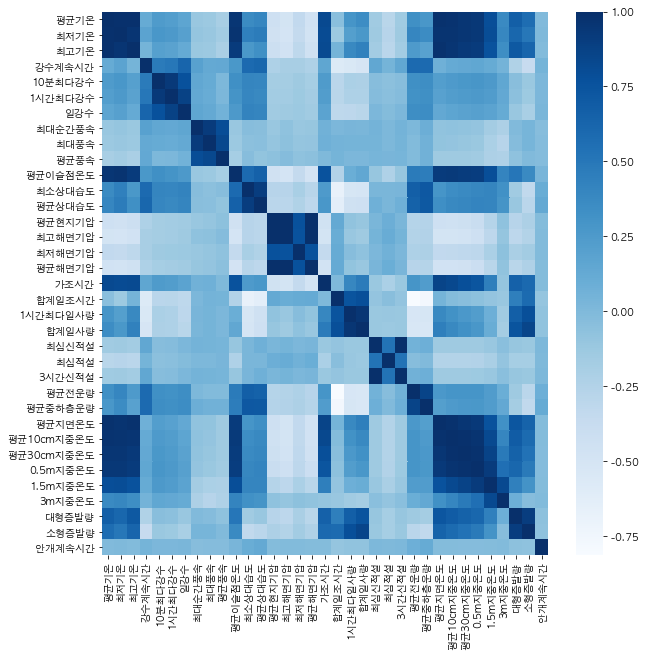

In [4]:

# 추출한 날씨데이터 가져오기
wth_df = pd.read_csv('wth_data_20211025.csv',index_col=0)
# Nan값 데이터 0으로 채우기
wth_df.fillna(0, inplace=True)
wth_df['tm'] = pd.to_datetime(wth_df['tm'])

# 날씨데이터의 index 날짜로 설명
wth_df = wth_df.set_index(wth_df['tm'])
wth_df.drop('tm', axis=1, inplace=True)
#레이블달기
label = {'avgTa':'평균기온', 'minTa':'최저기온', 'maxTa':'최고기온', 'sumRnDur':'강수계속시간', 'mi10MaxRn':'10분최다강수', 'hr1MaxRn':'1시간최다강수', 'sumRn':'일강수',
       'maxInsWs':'최대순간풍속', 'maxWs':'최대풍속', 'avgWs':'평균풍속', 'avgTd':'평균이슬점온도', 'minRhm':'최소상대습도', 'avgRhm':'평균상대습도', 'avgPa':'평균현지기압',
       'maxPs':'최고해면기압', 'minPs':'최저해면기압', 'avgPs':'평균해면기압', 'ssDur':'가조시간', 'sumSsHr':'합계일조시간', 'hr1MaxIcsr':'1시간최다일사량', 'sumGsr':'합계일사량',
       'ddMefs':'최심신적설', 'ddMes':'최심적설', 'sumDpthFhsc':'3시간신적설', 'avgTca':'평균전운량', 'avgLmac':'평균중하층운량', 'avgTs':'평균지면온도',
       'avgCm10Te':'평균10cm지중온도', 'avgCm30Te':'평균30cm지중온도', 'avgM05Te':'0.5m지중온도', 'avgM15Te':'1.5m지중온도', 'avgM30Te':'3m지중온도',
       'sumLrgEv':'대형증발량', 'sumSmlEv':'소형증발량', 'sumFogDur':'안개계속시간'}
wth_df = wth_df.rename(columns=label)
# 각 칼럼별 연관성 파악
wth_df.corr(method='pearson')
plt.figure(figsize =(10,10))
sns.heatmap(wth_df.corr(method='pearson'),cmap='Blues', fmt ='.2f')

In [35]:
len(df_list)

11

In [ ]:
# 코스피 코스닥 나누는 코드

In [ ]:
심볼	설명
KS11	KOSPI 지수
KQ11	KOSDAQ 지수
KS50	KOSPI 50 지수
KS100	KOSPI 100
KRX100	KRX 100
KS200	코스피 200

In [44]:
df_krx = fdr.StockListing('KRX')

In [50]:
kq = fdr.DataReader('KQ11', '2000')
kq.head(10)

,Close,Open,High,Low,Volume,Change
Date,,,,,,
2001-01-02,557.0,502.5,559.6,502.5,201210.0,0.0593
2001-01-03,569.0,545.8,579.9,539.3,284990.0,0.0215
2001-01-04,615.1,617.7,621.5,609.0,233130.0,0.0810
2001-01-05,625.2,614.5,630.7,602.5,367230.0,0.0164
2001-01-08,650.0,614.9,657.0,614.0,358620.0,0.0397
2001-01-09,678.2,660.6,678.2,650.4,457140.0,0.0434
2001-01-10,639.6,688.6,730.5,639.6,697320.0,-0.0569
2001-01-11,675.1,657.2,675.4,631.9,477200.0,0.0555
2001-01-12,713.6,703.0,732.9,699.0,502830.0,0.0570


In [45]:
df_krx.head(4)

,Symbol,Market,Name,Sector,Industry,ListingDate,SettleMonth,Representative,HomePage,Region
0,060310,KOSDAQ,3S,전자부품 제조업,반도체 웨이퍼 캐리어,2002-04-23,03월,"박종익, 김세완 (각자 대표이사)",http://www.3sref.com,서울특별시
1,095570,KOSPI,AJ네트웍스,산업용 기계 및 장비 임대업,"렌탈(파렛트, OA장비, 건설장비)",2015-08-21,12월,박대현,http://www.ajnet.co.kr,서울특별시
2,006840,KOSPI,AK홀딩스,기타 금융업,지주사업,1999-08-11,12월,"채형석, 이석주(각자 대표이사)",http://www.aekyunggroup.co.kr,서울특별시
3,054620,KOSDAQ,APS홀딩스,기타 금융업,인터넷 트래픽 솔루션,2001-12-04,12월,정기로,http://www.apsholdings.co.kr,경기도


In [ ]:
f

In [46]:
df_krx.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6940 entries, 0 to 6939
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Symbol          6940 non-null   object        
 1   Market          6940 non-null   object        
 2   Name            6940 non-null   object        
 3   Sector          2469 non-null   object        
 4   Industry        2450 non-null   object        
 5   ListingDate     2469 non-null   datetime64[ns]
 6   SettleMonth     2469 non-null   object        
 7   Representative  2469 non-null   object        
 8   HomePage        2321 non-null   object        
 9   Region          2469 non-null   object        
dtypes: datetime64[ns](1), object(9)
memory usage: 596.4+ KB


In [47]:
df_krx['Market'].value_counts()

KOSPI     5269
KOSDAQ    1538
KONEX      133
Name: Market, dtype: int64

In [ ]:
if

In [49]:
df_theme_code_result

,Close,Volume,Change,cd
Date,,,,
2000-01-04,7471,830800,0.149385,011930
2000-01-05,7068,593940,-0.053942,011930
2000-01-06,6710,563820,-0.050651,011930
2000-01-07,6683,529110,-0.004024,011930
2000-01-10,6738,531610,0.008230,011930
...,...,...,...,...
2021-10-14,94400,438346,0.026087,120110
2021-10-15,93900,368612,-0.005297,120110
2021-10-18,92600,273561,-0.013845,120110


# 두나무 관련 주 전체 결과 보는 코드

In [ ]:
# train/validation /test
# 다른 테마
# 시각화 어떻게 할지
# 다른 부스팅 모델
# 코스닥일 경우 코스당 지수랑 붙여야함

In [ ]:
# 샘 질문 - 코스피 지수 아예 칼럼 따로
# 트레인테스트/예측 어떻게 해야할지
# 예측이 되는 테마/ 안되는 테마

In [38]:
rfr.feature_importance_

AttributeError: 'RandomForestRegressor' object has no attribute 'feature_importance_'

# 머신러닝 

In [ ]:
# 코스피 

In [ ]:
# 코스피 영향만으로

In [40]:
pri_ks = pd.merge(df_list[0], ks, left_index=True, right_index=True)# 코스피+두나무관련주 데이터1번(신성이앤지)
pri_ks.head(1)

,Close_x,Volume_x,Change_x,cd,Close_y,Volume_y,Change_y
Date,,,,,,,
2000-01-04,7471,830800,0.149385,011930,1059.04,195900000.0,0.0301


In [ ]:
# target = 종가
# data= 코스피 종가

In [41]:
pri_ks = pd.merge(df_list[0], ks, left_index=True, right_index=True)# 코스피+두나무관련주 데이터1번(신성이앤지)

# x, y 구분
target = pri_ks['Close_x'].to_numpy()
data = pri_ks.drop(['Close_x', 'Volume_x', 'Change_x','cd','Volume_y','Change_y'], axis=1).to_numpy()
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(data, target, test_size=0.2, random_state=42)

# 표준화
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()
ss.fit(x_train)
tr_scaled =ss.transform(x_train)
ts_scaled =ss.transform(x_test)

from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
lr=LinearRegression()
kreg = KNeighborsRegressor()
rfr =RandomForestRegressor()

lr.fit(tr_scaled, y_train)
kreg.fit(tr_scaled, y_train)
rfr.fit(tr_scaled, y_train)


print('lr_score:', lr.score(tr_scaled, y_train))
print('lr_score_ts:', lr.score(ts_scaled, y_test))
print('----------------')
print('kr_score:', kreg.score(tr_scaled, y_train))
print('kr_score_ts:', kreg.score(ts_scaled, y_test))
print('----------------')
print('rfr_score:', rfr.score(tr_scaled, y_train))
print('rfr_score_ts:', rfr.score(ts_scaled, y_test))

lr_score: 0.1047602351043746
lr_score_ts: 0.10634473526349442
----------------
kr_score: 0.5026236255193243
kr_score_ts: 0.3150924173851779
----------------
rfr_score: 0.8638003110894443
rfr_score_ts: 0.14735005644988963


In [ ]:
# target = 변동률
# data= 코스피 종가

In [42]:
pri_ks = pd.merge(df_list[0], ks, left_index=True, right_index=True)# 코스피+두나무관련주 데이터1번(신성이앤지)

# x, y 구분
target = pri_ks['Change_x'].to_numpy()
data = pri_ks.drop(['Close_x', 'Volume_x', 'Change_x','cd','Volume_y','Change_y'], axis=1).to_numpy()
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(data, target, test_size=0.2, random_state=42)

# 표준화
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()
ss.fit(x_train)
tr_scaled =ss.transform(x_train)
ts_scaled =ss.transform(x_test)

# 모델 구축
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
lr=LinearRegression()
kreg = KNeighborsRegressor()
rfr =RandomForestRegressor()

lr.fit(tr_scaled, y_train)
kreg.fit(tr_scaled, y_train)
rfr.fit(tr_scaled, y_train)


print('lr_score:', lr.score(tr_scaled, y_train))
print('lr_score_ts:', lr.score(ts_scaled, y_test))
print('----------------')
print('kr_score:', kreg.score(tr_scaled, y_train))
print('kr_score_ts:', kreg.score(ts_scaled, y_test))
print('----------------')
print('rfr_score:', rfr.score(tr_scaled, y_train))
print('rfr_score_ts:', rfr.score(ts_scaled, y_test))

lr_score: 6.605667987247266e-05
lr_score_ts: -0.0006535491927108783
----------------
kr_score: 0.19535143112830478
kr_score_ts: -0.13436066950551573
----------------
rfr_score: 0.7803085746031647
rfr_score_ts: -0.34558586779739264


In [ ]:
# target = 종가
# data = 변동률

In [43]:
pri_ks = pd.merge(df_list[0], ks, left_index=True, right_index=True)# 코스피+두나무관련주 데이터1번(신성이앤지)

# x, y 구분
target = pri_ks['Change_x'].to_numpy()
data = pri_ks.drop(['Close_x', 'Volume_x', 'Change_x','cd','Volume_y','Close_y'], axis=1).to_numpy()
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(data, target, test_size=0.2, random_state=42)

# 표준화
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()
ss.fit(x_train)
tr_scaled =ss.transform(x_train)
ts_scaled =ss.transform(x_test)

# 모델 구축
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
lr=LinearRegression()
kreg = KNeighborsRegressor()
rfr =RandomForestRegressor()

lr.fit(tr_scaled, y_train)
kreg.fit(tr_scaled, y_train)
rfr.fit(tr_scaled, y_train)


print('lr_score:', lr.score(tr_scaled, y_train))
print('lr_score_ts:', lr.score(ts_scaled, y_test))
print('----------------')
print('kr_score:', kreg.score(tr_scaled, y_train))
print('kr_score_ts:', kreg.score(ts_scaled, y_test))
print('----------------')
print('rfr_score:', rfr.score(tr_scaled, y_train))
print('rfr_score_ts:', rfr.score(ts_scaled, y_test))

lr_score: 0.2319380272214684
lr_score_ts: 0.23391876750238294
----------------
kr_score: 0.26167858335901684
kr_score_ts: 0.0837765642720415
----------------
rfr_score: 0.3881888269146945
rfr_score_ts: 0.09352192695037997


In [ ]:
# 태양광주가/ 코스피 주가
# change(태양광)-change(코스피)
# 변화율  당일 3일 or~ 여러날 일주일//한달//


In [30]:
# 코스피 데이터프레임 파일 구축
import FinanceDataReader as fdr
ks = fdr.DataReader('KS11', '2000') 
ks.drop(['Open', 'High', 'Low'], axis =1, inplace =True)

# 기본 데이터셋 만들기
df_list[0].index = df_list[0].index.astype('datetime64[ns]')
pri_ks = pd.merge(df_list[0], ks, left_index=True, right_index=True)# 코스피+두나무관련주 데이터1번(신성이앤지)
#wth_al = pd.merge(wth_df, pri_ks, left_index=True, right_index=True)# 위 데이터+ 날씨

# x, y 구분
target = pri_ks['Close_x'].to_numpy()
data = pri_ks.drop(['Close_x', 'Volume_x', 'Change_x','cd','Volume_y','Change_y'], axis=1).to_numpy()
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(data, target, test_size=0.2, random_state=42)

# 표준화
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()
ss.fit(x_train)
tr_scaled =ss.transform(x_train)
ts_scaled =ss.transform(x_test)

# 모델 구축
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
lr=LinearRegression()
kreg = KNeighborsRegressor()
rfr =RandomForestRegressor()

lr.fit(tr_scaled, y_train)
kreg.fit(tr_scaled, y_train)
rfr.fit(tr_scaled, y_train)


print('lr_score:', lr.score(tr_scaled, y_train))
print('lr_score_ts:', lr.score(ts_scaled, y_test))
print('----------------')
print('kr_score:', kreg.score(tr_scaled, y_train))
print('kr_score_ts:', kreg.score(ts_scaled, y_test))
print('----------------')
print('rfr_score:', rfr.score(tr_scaled, y_train))
print('rfr_score_ts:', rfr.score(ts_scaled, y_test))

lr_score: 0.22475985818695143
lr_score_ts: 0.23919345319091456
----------------
kr_score: 0.4781675964975044
kr_score_ts: 0.22408447186347646
----------------
rfr_score: 0.9564148976619888
rfr_score_ts: 0.7227278614340682


# 사전 test 과정(안봐도됨)

In [43]:
for j in range(len(df_list)) : 
    df_list[j].index = df_list[j].index.astype('datetime64[ns]')
    factor_scores.index = factor_scores.index.astype('datetime64[ns]')

    join_df = factor_scores.join(df_list[j], how='inner') 

In [44]:
join_df.head()

,Factor1,Factor2,Factor3,Factor4,Close,Volume,Change,cd
2010-02-01,-1.301871,-0.209759,-0.179705,0.446462,43112,1212477,NaN,120110
2010-02-02,-1.471373,-1.125326,0.156134,0.994131,41008,543547,-0.048803,120110
2010-02-03,-1.428540,-0.708738,0.424063,1.108688,42878,486500,0.045601,120110
2010-02-04,-1.318276,-0.331733,0.420115,0.888002,42785,356454,-0.002169,120110
2010-02-05,-1.424644,-0.939647,0.304473,0.399238,41055,299920,-0.040435,120110


In [45]:
join_df.tail()

,Factor1,Factor2,Factor3,Factor4,Close,Volume,Change,cd
2021-10-14,0.902072,0.288568,0.411471,-1.021298,94400,438346,0.026087,120110
2021-10-15,0.737596,1.162101,0.321989,-1.413378,93900,368612,-0.005297,120110
2021-10-18,0.148427,0.401513,0.888229,-1.126577,92600,273561,-0.013845,120110
2021-10-19,0.232878,0.108322,0.563950,-0.090095,91800,291643,-0.008639,120110
2021-10-20,0.167423,-0.713052,0.629800,-1.124137,96500,831325,0.051198,120110


# 날씨+ 두나무관련주

In [ ]:
# 코스피 머지

In [65]:
import FinanceDataReader as fdr

In [66]:
ks = fdr.DataReader('KS11', '2000') # kospi

In [83]:
ks.columns

Index(['Close', 'Open', 'High', 'Low', 'Volume', 'Change'], dtype='object')

In [85]:
ks.drop(['Open', 'High', 'Low'], axis =1, inplace =True)

In [86]:
pri_ks = pd.merge(df_list[0], ks, left_index=True, right_index=True)

In [87]:
pri_ks.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5381 entries, 2000-01-04 to 2021-10-20
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Close_x   5381 non-null   int64  
 1   Volume_x  5381 non-null   int64  
 2   Change_x  5381 non-null   float64
 3   cd        5381 non-null   object 
 4   Close_y   5381 non-null   float64
 5   Volume_y  5381 non-null   float64
 6   Change_y  5381 non-null   float64
dtypes: float64(4), int64(2), object(1)
memory usage: 336.3+ KB


In [96]:
pri_ks.head(1)

,Close_x,Volume_x,Change_x,cd,Close_y,Volume_y,Change_y
Date,,,,,,,
2000-01-04,7471,830800,0.149385,011930,1059.04,195900000.0,0.0301


In [88]:
xc= pri_ks.iloc[2000:, :].corr()

<AxesSubplot:>

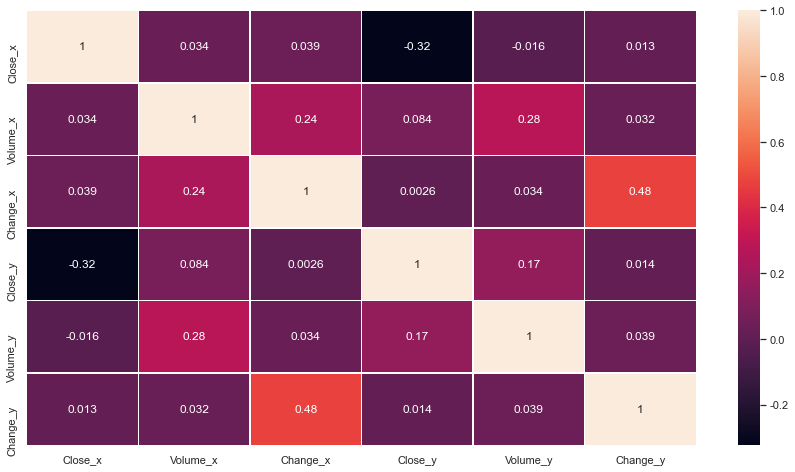

In [89]:
z= pri_ks.corr()
sns.set(rc = {'figure.figsize':(15,8)})
sns.heatmap(z ,annot=True, linewidths=.5)
# x 첨자 : 두나무 0번
# y 첨자: 코스피

<AxesSubplot:>

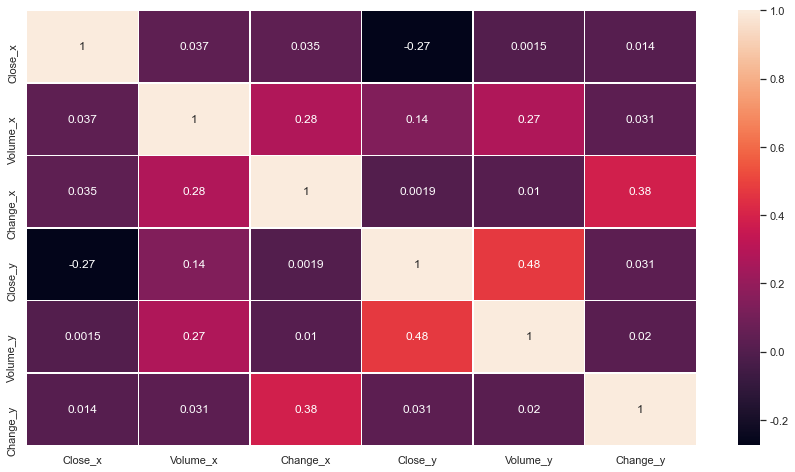

In [90]:
sns.set(rc = {'figure.figsize':(15,8)})
sns.heatmap(xc ,annot=True, linewidths=.5)

In [ ]:
# 날씨 머지

In [93]:
wth_df.columns

Index(['평균기온', '최저기온', '최고기온', '강수계속시간', '10분최다강수', '1시간최다강수', '일강수', '최대순간풍속',
       '최대풍속', '평균풍속', '평균이슬점온도', '최소상대습도', '평균상대습도', '평균현지기압', '최고해면기압',
       '최저해면기압', '평균해면기압', '가조시간', '합계일조시간', '1시간최다일사량', '합계일사량', '최심신적설',
       '최심적설', '3시간신적설', '평균전운량', '평균중하층운량', '평균지면온도', '평균10cm지중온도',
       '평균30cm지중온도', '0.5m지중온도', '1.5m지중온도', '3m지중온도', '대형증발량', '소형증발량',
       '안개계속시간'],
      dtype='object')

In [139]:
wth_df.head(1)

,평균기온,최저기온,최고기온,강수계속시간,10분최다강수,1시간최다강수,일강수,최대순간풍속,최대풍속,평균풍속,...,평균중하층운량,평균지면온도,평균10cm지중온도,평균30cm지중온도,0.5m지중온도,1.5m지중온도,3m지중온도,대형증발량,소형증발량,안개계속시간
tm,,,,,,,,,,,,,,,,,,,,,
2000-01-01,5.5,1.8,9.9,0.0,0.0,0.0,0.0,7.4,4.0,2.3,...,2.1,3.2,0.1,1.3,3.5,10.0,14.6,0.0,0.9,0.0


In [141]:
pri_ks.head(1)

,Close_x,Volume_x,Change_x,cd,Close_y,Volume_y,Change_y
Date,,,,,,,
2000-01-04,7471,830800,0.149385,011930,1059.04,195900000.0,0.0301


# 기본 데이터 추출

In [94]:
wth_al = pd.merge(wth_df, pri_ks, left_index=True, right_index=True)

In [99]:
wth_al.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5381 entries, 2000-01-04 to 2021-10-20
Data columns (total 42 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   평균기온        5381 non-null   float64
 1   최저기온        5381 non-null   float64
 2   최고기온        5381 non-null   float64
 3   강수계속시간      5381 non-null   float64
 4   10분최다강수     5381 non-null   float64
 5   1시간최다강수     5381 non-null   float64
 6   일강수         5381 non-null   float64
 7   최대순간풍속      5381 non-null   float64
 8   최대풍속        5381 non-null   float64
 9   평균풍속        5381 non-null   float64
 10  평균이슬점온도     5381 non-null   float64
 11  최소상대습도      5381 non-null   float64
 12  평균상대습도      5381 non-null   float64
 13  평균현지기압      5381 non-null   float64
 14  최고해면기압      5381 non-null   float64
 15  최저해면기압      5381 non-null   float64
 16  평균해면기압      5381 non-null   float64
 17  가조시간        5381 non-null   float64
 18  합계일조시간      5381 non-null   float64
 19  1시간최다일사량 

In [100]:
wth_al.head(1)

,평균기온,최저기온,최고기온,강수계속시간,10분최다강수,1시간최다강수,일강수,최대순간풍속,최대풍속,평균풍속,...,대형증발량,소형증발량,안개계속시간,Close_x,Volume_x,Change_x,cd,Close_y,Volume_y,Change_y
2000-01-04,0.3,-4.3,4.3,0.0,0.0,0.0,0.0,4.5,3.0,1.7,...,0.0,0.7,0.0,7471,830800,0.149385,011930,1059.04,195900000.0,0.0301


In [101]:
q=wth_al.corr()

/Users/parksinae/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 54217 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/parksinae/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 44512 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/parksinae/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 44592 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/parksinae/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 50728 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/parksinae/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 52572 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/parksinae/opt/anaconda3/lib/python3.8/

<AxesSubplot:>

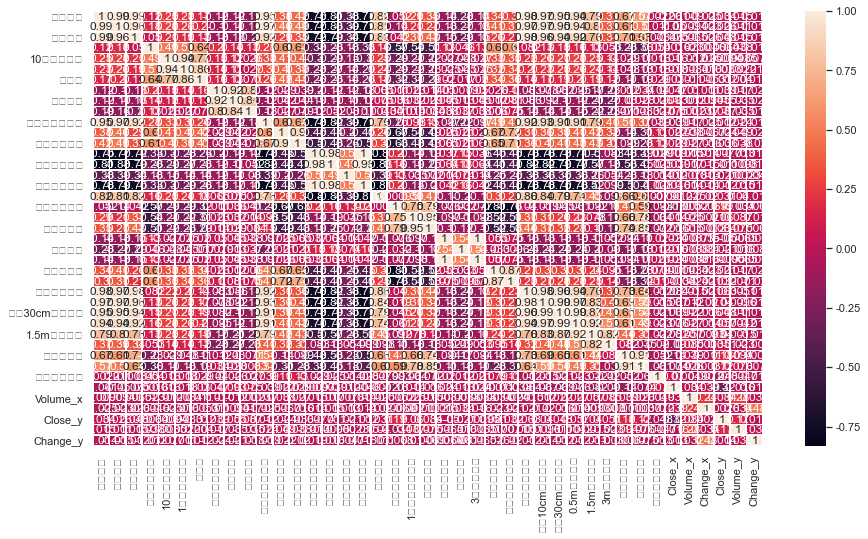

In [102]:
sns.set(rc = {'figure.figsize':(15,8)})
sns.heatmap(q ,annot=True, linewidths=.5)

# 머신러닝

In [1]:
####################################################################################################

# 머신러닝 시작1

In [114]:
from sklearn.preprocessing import StandardScaler


In [104]:
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor

In [106]:
from sklearn.model_selection import train_test_split

In [115]:
y = wth_al.loc[:,'Change_x']
x = wth_al.drop('Change_x', axis=1)

In [116]:
x_train, x_test, y_train,y_test = train_test_split(x, y, random_state=3)

In [117]:
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()
ss.fit(x_train)

StandardScaler()

In [119]:
x_tr = ss.transform(x_train)

In [120]:
x_test_tr =ss.transform(x_test)

In [112]:
lr=LinearRegression()
kreg = KNeighborsRegressor()
rfr =RandomForestRegressor()

In [121]:
lr.fit(x_train, y_train)
kreg.fit(x_train, y_train)
rfr.fit(x_train, y_train)

RandomForestRegressor()

In [122]:
lr_preds =lr.predict(x_test_tr)
kr_preds = kreg.predict(x_test_tr)
rfr_preds =rfr.predict(x_test_tr)

from sklearn.metrics import r2_score
print('lr_score:', r2_score(y_test, lr_preds))
print('kr_score:', r2_score(y_test, krg_preds))
print('rfr_score:', r2_score(y_test, rfr_preds))

lr_socre: -1090.1104227004244
kr_socre: -0.004869346118771434
rfr_socre: -3.352759014322344


In [125]:
lr_preds =lr.predict(x_test_tr)
kr_preds = kreg.predict(x_test_tr)
rfr_preds =rfr.predict(x_test_tr)

from sklearn.metrics import r2_score
print('lr_score:', r2_score(y_test, lr_preds))
print('kr_score:', r2_score(y_test, kr_preds))
print('rfr_score:', r2_score(y_test, rfr_preds))

lr_score: -1090.1104227004244
kr_score: -0.004869346118771434
rfr_score: -3.352759014322344


### 스코어가 마이너스값
- feature_importance_ 도 안먹힘
- 기본적인 것 까먹은 듯

# 머신러닝 2

In [137]:
wth_al.head(1)

,평균기온,최저기온,최고기온,강수계속시간,10분최다강수,1시간최다강수,일강수,최대순간풍속,최대풍속,평균풍속,...,대형증발량,소형증발량,안개계속시간,Close_x,Volume_x,Change_x,cd,Close_y,Volume_y,Change_y
2000-01-04,0.3,-4.3,4.3,0.0,0.0,0.0,0.0,4.5,3.0,1.7,...,0.0,0.7,0.0,7471,830800,0.149385,011930,1059.04,195900000.0,0.0301


In [138]:
wth_al.tail(1)

,평균기온,최저기온,최고기온,강수계속시간,10분최다강수,1시간최다강수,일강수,최대순간풍속,최대풍속,평균풍속,...,대형증발량,소형증발량,안개계속시간,Close_x,Volume_x,Change_x,cd,Close_y,Volume_y,Change_y
2021-10-20,9.5,4.6,15.8,0.0,0.0,0.0,0.0,5.9,3.7,1.7,...,2.6,3.7,0.0,2270,844828,-0.008734,011930,3013.13,680330000.0,-0.0053


In [143]:
target = wth_al['Change_x'].to_numpy()
data = wth_al.drop(['Volume_x', 'Change_x','cd','Volume_y','Change_y'], axis=1).to_numpy()

In [145]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(data, target, test_size=0.2, random_state=42)

In [146]:
print(x_train.shape, x_test.shape)
print(y_train.shape, y_test.shape)

(4304, 37) (1077, 37)
(4304,) (1077,)


In [147]:
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()
ss.fit(x_train)
tr_scaled =ss.transform(x_train)
ts_scaled =ss.transform(x_test)

In [148]:
lr=LinearRegression()
kreg = KNeighborsRegressor()
rfr =RandomForestRegressor()

In [149]:
lr.fit(tr_scaled, y_train)
kreg.fit(tr_scaled, y_train)
rfr.fit(tr_scaled, y_train)

RandomForestRegressor()

In [150]:
print('lr_score:', lr.score(tr_scaled, y_train))
print('lr_score_ts:', lr.score(ts_scaled, y_test))
print('----------------')
print('kr_score:', kreg.score(tr_scaled, y_train))
print('kr_score_ts:', kreg.score(ts_scaled, y_test))
print('----------------')
print('rfr_score:', rfr.score(tr_scaled, y_train))
print('rfr_score_ts:', rfr.score(ts_scaled, y_test))

lr_score: 0.009549999274482746
lr_score_ts: -0.00421257344226289
----------------
kr_score: 0.22594902872823397
kr_score_ts: -0.14922034011661522
----------------
rfr_score: 0.8539234226925914
rfr_score_ts: -0.0566688482381521


In [ ]:
target = wth_al['Change_x'].to_numpy()
data = wth_al.drop(['Volume_x', 'Change_x','cd','Volume_y','Change_y'], axis=1).to_numpy()
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(data, target, test_size=0.2, random_state=42)
print(x_train.shape, x_test.shape)
print(y_train.shape, y_test.shape)

from sklearn.preprocessing import StandardScaler
ss = StandardScaler()
ss.fit(x_train)
tr_scaled =ss.transform(x_train)
ts_scaled =ss.transform(x_test)

lr=LinearRegression()
kreg = KNeighborsRegressor()
rfr =RandomForestRegressor()

lr.fit(tr_scaled, y_train)
kreg.fit(tr_scaled, y_train)
rfr.fit(tr_scaled, y_train)


print('lr_score:', lr.score(tr_scaled, y_train))
print('lr_score_ts:', lr.score(ts_scaled, y_test))
print('----------------')
print('kr_score:', kreg.score(tr_scaled, y_train))
print('kr_score_ts:', kreg.score(ts_scaled, y_test))
print('----------------')
print('rfr_score:', rfr.score(tr_scaled, y_train))
print('rfr_score_ts:', rfr.score(ts_scaled, y_test))

# 머신 3

In [ ]:
# 최신데이터 범위 줄여서 : 예측력 더 낮아짐

In [156]:
target = wth_al['Change_x'][2000:].to_numpy()
data = wth_al.drop(['Volume_x', 'Change_x','cd','Volume_y','Change_y'], axis=1)[2000:].to_numpy()
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(data, target, test_size=0.2, random_state=42)
print(x_train.shape, x_test.shape)
print(y_train.shape, y_test.shape)

from sklearn.preprocessing import StandardScaler
ss = StandardScaler()
ss.fit(x_train)
tr_scaled =ss.transform(x_train)
ts_scaled =ss.transform(x_test)

lr=LinearRegression()
kreg = KNeighborsRegressor()
rfr =RandomForestRegressor()

lr.fit(tr_scaled, y_train)
kreg.fit(tr_scaled, y_train)
rfr.fit(tr_scaled, y_train)


print('lr_score:', lr.score(tr_scaled, y_train))
print('lr_score_ts:', lr.score(ts_scaled, y_test))
print('----------------')
print('kr_score:', kreg.score(tr_scaled, y_train))
print('kr_score_ts:', kreg.score(ts_scaled, y_test))
print('----------------')
print('rfr_score:', rfr.score(tr_scaled, y_train))
print('rfr_score_ts:', rfr.score(ts_scaled, y_test))

(2704, 37) (677, 37)
(2704,) (677,)
lr_score: 0.011758226931754878
lr_score_ts: -0.015183897363594934
----------------
kr_score: 0.23405065040312445
kr_score_ts: -0.26006001474417806
----------------
rfr_score: 0.8478891978032816
rfr_score_ts: -0.07089447662381154


# 머신4

In [160]:
target = wth_al['Change_x'][3000:].to_numpy()
data = wth_al.drop(['Volume_x', 'Change_x','cd','Volume_y','Change_y'], axis=1)[3000:].to_numpy()
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(data, target, test_size=0.2, random_state=42)
print(x_train.shape, x_test.shape)
print(y_train.shape, y_test.shape)

from sklearn.preprocessing import StandardScaler
ss = StandardScaler()
ss.fit(x_train)
tr_scaled =ss.transform(x_train)
ts_scaled =ss.transform(x_test)

lr=LinearRegression()
kreg = KNeighborsRegressor()
rfr =RandomForestRegressor()

lr.fit(tr_scaled, y_train)
kreg.fit(tr_scaled, y_train)
rfr.fit(tr_scaled, y_train)


print('lr_score:', lr.score(tr_scaled, y_train))
print('lr_score_ts:', lr.score(ts_scaled, y_test))
print('----------------')
print('kr_score:', kreg.score(tr_scaled, y_train))
print('kr_score_ts:', kreg.score(ts_scaled, y_test))
print('----------------')
print('rfr_score:', rfr.score(tr_scaled, y_train))
print('rfr_score_ts:', rfr.score(ts_scaled, y_test))

(1904, 37) (477, 37)
(1904,) (477,)
lr_score: 0.020779480462858824
lr_score_ts: -0.8167005073863276
----------------
kr_score: 0.19929691231815205
kr_score_ts: -0.2130894739300382
----------------
rfr_score: 0.8480271992719335
rfr_score_ts: -0.1284284852096913


# 머신5

In [161]:
target = wth_al['Change_x'][4000:].to_numpy()
data = wth_al.drop(['Volume_x', 'Change_x','cd','Volume_y','Change_y'], axis=1)[4000:].to_numpy()
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(data, target, test_size=0.2, random_state=42)
print(x_train.shape, x_test.shape)
print(y_train.shape, y_test.shape)

from sklearn.preprocessing import StandardScaler
ss = StandardScaler()
ss.fit(x_train)
tr_scaled =ss.transform(x_train)
ts_scaled =ss.transform(x_test)

lr=LinearRegression()
kreg = KNeighborsRegressor()
rfr =RandomForestRegressor()

lr.fit(tr_scaled, y_train)
kreg.fit(tr_scaled, y_train)
rfr.fit(tr_scaled, y_train)


print('lr_score:', lr.score(tr_scaled, y_train))
print('lr_score_ts:', lr.score(ts_scaled, y_test))
print('----------------')
print('kr_score:', kreg.score(tr_scaled, y_train))
print('kr_score_ts:', kreg.score(ts_scaled, y_test))
print('----------------')
print('rfr_score:', rfr.score(tr_scaled, y_train))
print('rfr_score_ts:', rfr.score(ts_scaled, y_test))

(1104, 37) (277, 37)
(1104,) (277,)
lr_score: 0.02468077558675419
lr_score_ts: -0.03338319677177193
----------------
kr_score: 0.20814602324612685
kr_score_ts: -0.24882510582511808
----------------
rfr_score: 0.8434371046513014
rfr_score_ts: -0.1544087433601915


# 머신6

In [163]:
target = wth_al['Change_x'][4500:].to_numpy()
data = wth_al.drop(['Volume_x', 'Change_x','cd','Volume_y','Change_y'], axis=1)[4500:].to_numpy()
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(data, target, test_size=0.2, random_state=42)
print(x_train.shape, x_test.shape)
print(y_train.shape, y_test.shape)

from sklearn.preprocessing import StandardScaler
ss = StandardScaler()
ss.fit(x_train)
tr_scaled =ss.transform(x_train)
ts_scaled =ss.transform(x_test)

lr=LinearRegression()
kreg = KNeighborsRegressor()
rfr =RandomForestRegressor()

lr.fit(tr_scaled, y_train)
kreg.fit(tr_scaled, y_train)
rfr.fit(tr_scaled, y_train)


print('lr_score:', lr.score(tr_scaled, y_train))
print('lr_score_ts:', lr.score(ts_scaled, y_test))
print('----------------')
print('kr_score:', kreg.score(tr_scaled, y_train))
print('kr_score_ts:', kreg.score(ts_scaled, y_test))
print('----------------')
print('rfr_score:', rfr.score(tr_scaled, y_train))
print('rfr_score_ts:', rfr.score(ts_scaled, y_test))

(704, 37) (177, 37)
(704,) (177,)
lr_score: 0.059120906615685254
lr_score_ts: -0.09191222282626899
----------------
kr_score: 0.22204640105678108
kr_score_ts: -0.29344933643327265
----------------
rfr_score: 0.8295742961292947
rfr_score_ts: -0.22864888528918192


# 머신7:new - 종가로 바꿈

In [164]:
target = wth_al['Close_x'].to_numpy()
data = wth_al.drop(['Close_x', 'Volume_x', 'Change_x','cd','Volume_y','Change_y'], axis=1).to_numpy()
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(data, target, test_size=0.2, random_state=42)
print(x_train.shape, x_test.shape)
print(y_train.shape, y_test.shape)

from sklearn.preprocessing import StandardScaler
ss = StandardScaler()
ss.fit(x_train)
tr_scaled =ss.transform(x_train)
ts_scaled =ss.transform(x_test)

lr=LinearRegression()
kreg = KNeighborsRegressor()
rfr =RandomForestRegressor()

lr.fit(tr_scaled, y_train)
kreg.fit(tr_scaled, y_train)
rfr.fit(tr_scaled, y_train)


print('lr_score:', lr.score(tr_scaled, y_train))
print('lr_score_ts:', lr.score(ts_scaled, y_test))
print('----------------')
print('kr_score:', kreg.score(tr_scaled, y_train))
print('kr_score_ts:', kreg.score(ts_scaled, y_test))
print('----------------')
print('rfr_score:', rfr.score(tr_scaled, y_train))
print('rfr_score_ts:', rfr.score(ts_scaled, y_test))

(4304, 36) (1077, 36)
(4304,) (1077,)
lr_score: 0.22475985818695143
lr_score_ts: 0.23919345319091456
----------------
kr_score: 0.4781675964975044
kr_score_ts: 0.22408447186347646
----------------
rfr_score: 0.9570265794028977
rfr_score_ts: 0.7218760779659121


# 7-1 변수 조정
- 코스피 관련 종가뿐 아니라 나머지도 투입

In [167]:
target = wth_al['Close_x'].to_numpy()
data = wth_al.drop(['Close_x', 'Volume_x', 'Change_x','cd'], axis=1).to_numpy()
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(data, target, test_size=0.2, random_state=42)
print(x_train.shape, x_test.shape)
print(y_train.shape, y_test.shape)

from sklearn.preprocessing import StandardScaler
ss = StandardScaler()
ss.fit(x_train)
tr_scaled =ss.transform(x_train)
ts_scaled =ss.transform(x_test)

lr=LinearRegression()
kreg = KNeighborsRegressor()
rfr =RandomForestRegressor()

lr.fit(tr_scaled, y_train)
kreg.fit(tr_scaled, y_train)
rfr.fit(tr_scaled, y_train)


print('lr_score:', lr.score(tr_scaled, y_train))
print('lr_score_ts:', lr.score(ts_scaled, y_test))
print('----------------')
print('kr_score:', kreg.score(tr_scaled, y_train))
print('kr_score_ts:', kreg.score(ts_scaled, y_test))
print('----------------')
print('rfr_score:', rfr.score(tr_scaled, y_train))
print('rfr_score_ts:', rfr.score(ts_scaled, y_test))

(4304, 38) (1077, 38)
(4304,) (1077,)
lr_score: 0.2254963842695047
lr_score_ts: 0.23929896864615974
----------------
kr_score: 0.4701145203875512
kr_score_ts: 0.235607051784972
----------------
rfr_score: 0.9589048038835499
rfr_score_ts: 0.7275249176798573


# 머신 8 - 거래량

In [166]:
target = wth_al['Volume_x'].to_numpy()
data = wth_al.drop(['Close_x', 'Volume_x', 'Change_x','cd','Change_y'], axis=1).to_numpy()
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(data, target, test_size=0.2, random_state=42)
print(x_train.shape, x_test.shape)
print(y_train.shape, y_test.shape)

from sklearn.preprocessing import StandardScaler
ss = StandardScaler()
ss.fit(x_train)
tr_scaled =ss.transform(x_train)
ts_scaled =ss.transform(x_test)

lr=LinearRegression()
kreg = KNeighborsRegressor()
rfr =RandomForestRegressor()

lr.fit(tr_scaled, y_train)
kreg.fit(tr_scaled, y_train)
rfr.fit(tr_scaled, y_train)


print('lr_score:', lr.score(tr_scaled, y_train))
print('lr_score_ts:', lr.score(ts_scaled, y_test))
print('----------------')
print('kr_score:', kreg.score(tr_scaled, y_train))
print('kr_score_ts:', kreg.score(ts_scaled, y_test))
print('----------------')
print('rfr_score:', rfr.score(tr_scaled, y_train))
print('rfr_score_ts:', rfr.score(ts_scaled, y_test))

(4304, 37) (1077, 37)
(4304,) (1077,)
lr_score: 0.09263748754107792
lr_score_ts: 0.1069410309032115
----------------
kr_score: 0.486100531423194
kr_score_ts: 0.10360635032403698
----------------
rfr_score: 0.8996834577858375
rfr_score_ts: 0.12535663628748428
